# 準備

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys

In [ ]:
dirpath = '/content/drive/MyDrive/RapidChallenge/DNN'

if dirpath not in sys.path:
  sys.path.append('/content/drive/MyDrive/RapidChallenge/DNN')

# importと関数定義

In [ ]:
import numpy as np
from common import layers
from collections import OrderedDict
from common import functions
from data.mnist import load_mnist
import matplotlib.pyplot as plt
from multi_layer_net import MultiLayerNet
from common import optimizer

# 深層学習全体の復習

## 確認テスト

- 連鎖律の原理を使い、使い、dz/dxを求めよ

  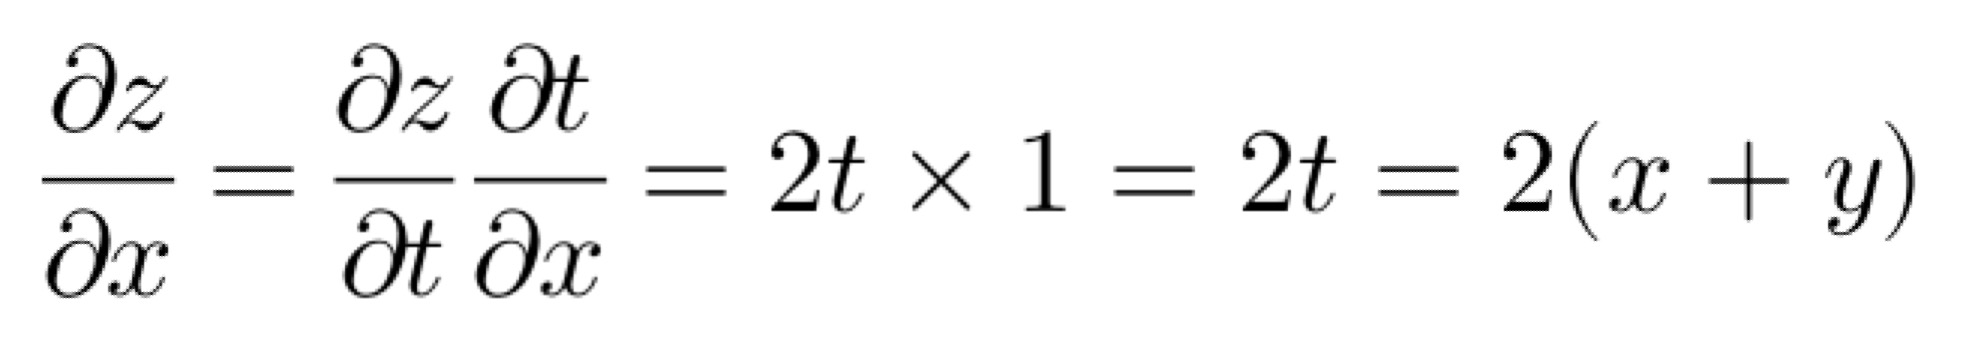

# Section1: 勾配消失問題

## 要点のまとめ

- 復習

  勾配消失問題とは:　誤差逆伝播法が下位層に進んでいくにつれて、勾配が緩やかになっていく。そのため、勾配降下法による更新では下位層のパラメータはほとんど変わらず、学習結果が最適値に収束しない


- 勾配消失問題は、活性化関数の選び方、重みの初期値の設定方法、バッチ正規化で解決する

  - 活性化関数はReLU関数がよく使われる。0以上の入力に対して微分が1になることで勾配消失が発生しない

  - 重みの初期値の設定方法は、XavierやHeなどのようにランダムに振ることで、重みの均一化で学習不可になる問題を回避する

  - バッチ正規化は、ミニバッチ単位で入力の偏りを抑制する。中間層の重み更新を安定化させることで学習速度を向上したり、過学習を抑制できる

## 確認テスト

- シグモイド関数を微分したとき、入力値が0の時に最大値をとる。その時の値は？

  (2) 0.25

In [ ]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

def sigmoid_d(x):
    return (1 - sigmoid(x)) * sigmoid(x)

print(sigmoid_d(0.25))

0.24613408273759835


- 重みの初期値に0を設定すると、どのような問題が起きるか？？

  正しい学習が行えない。すべての重みが均一になって更新されるので、多数の重みを持つ意味がなくなる

- バッチ正規化の効果を効果を2つ挙げよ
  - 中間層の重み更新を安定化して、学習速度を向上できる
  - 過学習を抑制できる

## 多層ネットワーククラス

In [ ]:
class MultiLayerNet:
    '''
    input_size: 入力層のノード数
    hidden_size_list: 隠れ層のノード数のリスト
    output_size: 出力層のノード数
    activation: 活性化関数
    weight_init_std: 重みの初期化方法
    '''
    def __init__(self, input_size, hidden_size_list, output_size, activation='relu', weight_init_std='relu'):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size_list = hidden_size_list
        self.hidden_layer_num = len(hidden_size_list)
        self.params = {}

        # 重みの初期化
        self.__init_weight(weight_init_std)

        # レイヤの生成, sigmoidとreluのみ扱う
        activation_layer = {'sigmoid': layers.Sigmoid, 'relu': layers.Relu}
        self.layers = OrderedDict() # 追加した順番に格納
        for idx in range(1, self.hidden_layer_num+1):
            self.layers['Affine' + str(idx)] = layers.Affine(self.params['W' + str(idx)], self.params['b' + str(idx)])
            self.layers['Activation_function' + str(idx)] = activation_layer[activation]()

        idx = self.hidden_layer_num + 1
        self.layers['Affine' + str(idx)] = layers.Affine(self.params['W' + str(idx)], self.params['b' + str(idx)])

        self.last_layer = layers.SoftmaxWithLoss()

    def __init_weight(self, weight_init_std):
        all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]
        for idx in range(1, len(all_size_list)):
            scale = weight_init_std
            if str(weight_init_std).lower() in ('relu', 'he'):
                scale = np.sqrt(2.0 / all_size_list[idx - 1])
            elif str(weight_init_std).lower() in ('sigmoid', 'xavier'):
                scale = np.sqrt(1.0 / all_size_list[idx - 1])

            self.params['W' + str(idx)] = scale * np.random.randn(all_size_list[idx-1], all_size_list[idx])
            self.params['b' + str(idx)] = np.zeros(all_size_list[idx])

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, d):
        y = self.predict(x)

        weight_decay = 0
        for idx in range(1, self.hidden_layer_num + 2):
            W = self.params['W' + str(idx)]

        return self.last_layer.forward(y, d) + weight_decay

    def accuracy(self, x, d):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if d.ndim != 1 : d = np.argmax(d, axis=1)

        accuracy = np.sum(y == d) / float(x.shape[0])
        return accuracy

    def gradient(self, x, d):
        # forward
        self.loss(x, d)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grad = {}
        for idx in range(1, self.hidden_layer_num+2):
            grad['W' + str(idx)] = self.layers['Affine' + str(idx)].dW
            grad['b' + str(idx)] = self.layers['Affine' + str(idx)].db

        return grad

- MultiLayerNetクラスのオブジェクト生成時に、hidden_size_listの長さが中間層の数になる。たとえば、[10,20,30]とすると中間層は中間層は3つで、それぞれ10個、20個、30個のノードを持つ

## 勾配消失問題

### sigmoid-gauss

データ読み込み完了
Generation: 10. 正答率(トレーニング) = 0.16
                : 10. 正答率(テスト) = 0.1032
Generation: 20. 正答率(トレーニング) = 0.11
                : 20. 正答率(テスト) = 0.1135
Generation: 30. 正答率(トレーニング) = 0.14
                : 30. 正答率(テスト) = 0.1032
Generation: 40. 正答率(トレーニング) = 0.14
                : 40. 正答率(テスト) = 0.0974
Generation: 50. 正答率(トレーニング) = 0.14
                : 50. 正答率(テスト) = 0.1135
Generation: 60. 正答率(トレーニング) = 0.13
                : 60. 正答率(テスト) = 0.1009
Generation: 70. 正答率(トレーニング) = 0.09
                : 70. 正答率(テスト) = 0.1135
Generation: 80. 正答率(トレーニング) = 0.08
                : 80. 正答率(テスト) = 0.1135
Generation: 90. 正答率(トレーニング) = 0.08
                : 90. 正答率(テスト) = 0.1135
Generation: 100. 正答率(トレーニング) = 0.11
                : 100. 正答率(テスト) = 0.1135
Generation: 110. 正答率(トレーニング) = 0.17
                : 110. 正答率(テスト) = 0.1135
Generation: 120. 正答率(トレーニング) = 0.09
                : 120. 正答率(テスト) = 0.1135
Generation: 130. 正答率(トレーニング) = 0.11
                : 130. 正答率(テスト) = 0.1135
Generat

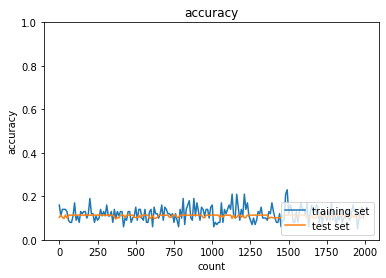

In [ ]:
# データの読み込み
(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True, one_hot_label=True)

print("データ読み込み完了")

network = MultiLayerNet(input_size=784, hidden_size_list=[40, 20], output_size=10, activation='sigmoid', weight_init_std=0.01)

iters_num = 2000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval=10

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    # 勾配
    grad = network.gradient(x_batch, d_batch)
    
    for key in ('W1', 'W2', 'W3', 'b1', 'b2', 'b3'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, d_batch)
    train_loss_list.append(loss)
    
    if (i + 1) % plot_interval == 0:
        accr_test = network.accuracy(x_test, d_test)
        accuracies_test.append(accr_test)        
        accr_train = network.accuracy(x_batch, d_batch)
        accuracies_train.append(accr_train)

        print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
        print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))
        

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()

### ReLU-gauss

データ読み込み完了
Generation: 10. 正答率(トレーニング) = 0.09
                : 10. 正答率(テスト) = 0.1009
Generation: 20. 正答率(トレーニング) = 0.13
                : 20. 正答率(テスト) = 0.1135
Generation: 30. 正答率(トレーニング) = 0.11
                : 30. 正答率(テスト) = 0.1135
Generation: 40. 正答率(トレーニング) = 0.14
                : 40. 正答率(テスト) = 0.1135
Generation: 50. 正答率(トレーニング) = 0.05
                : 50. 正答率(テスト) = 0.1135
Generation: 60. 正答率(トレーニング) = 0.18
                : 60. 正答率(テスト) = 0.1135
Generation: 70. 正答率(トレーニング) = 0.14
                : 70. 正答率(テスト) = 0.1135
Generation: 80. 正答率(トレーニング) = 0.13
                : 80. 正答率(テスト) = 0.1135
Generation: 90. 正答率(トレーニング) = 0.16
                : 90. 正答率(テスト) = 0.1135
Generation: 100. 正答率(トレーニング) = 0.15
                : 100. 正答率(テスト) = 0.1135
Generation: 110. 正答率(トレーニング) = 0.09
                : 110. 正答率(テスト) = 0.1135
Generation: 120. 正答率(トレーニング) = 0.15
                : 120. 正答率(テスト) = 0.1135
Generation: 130. 正答率(トレーニング) = 0.15
                : 130. 正答率(テスト) = 0.1135
Generat

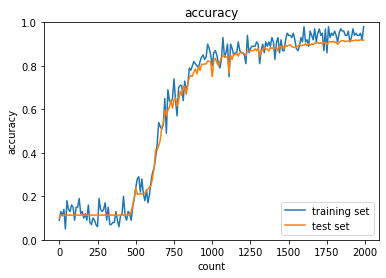

In [ ]:
# データの読み込み
(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True, one_hot_label=True)

print("データ読み込み完了")

network = MultiLayerNet(input_size=784, hidden_size_list=[40, 20], output_size=10, activation='relu', weight_init_std=0.01)

iters_num = 2000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval=10

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    # 勾配
    grad = network.gradient(x_batch, d_batch)
    
    for key in ('W1', 'W2', 'W3', 'b1', 'b2', 'b3'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, d_batch)
    train_loss_list.append(loss)
    
    if (i + 1) % plot_interval == 0:
        accr_test = network.accuracy(x_test, d_test)
        accuracies_test.append(accr_test)        
        accr_train = network.accuracy(x_batch, d_batch)
        accuracies_train.append(accr_train)

        print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
        print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))
        
        
lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()

sigmoid-Xavier

データ読み込み完了
Generation: 10. 正答率(トレーニング) = 0.11
                : 10. 正答率(テスト) = 0.1187
Generation: 20. 正答率(トレーニング) = 0.16
                : 20. 正答率(テスト) = 0.1714
Generation: 30. 正答率(トレーニング) = 0.13
                : 30. 正答率(テスト) = 0.1142
Generation: 40. 正答率(トレーニング) = 0.17
                : 40. 正答率(テスト) = 0.191
Generation: 50. 正答率(トレーニング) = 0.08
                : 50. 正答率(テスト) = 0.1213
Generation: 60. 正答率(トレーニング) = 0.14
                : 60. 正答率(テスト) = 0.1138
Generation: 70. 正答率(トレーニング) = 0.23
                : 70. 正答率(テスト) = 0.2061
Generation: 80. 正答率(トレーニング) = 0.13
                : 80. 正答率(テスト) = 0.1161
Generation: 90. 正答率(トレーニング) = 0.29
                : 90. 正答率(テスト) = 0.1987
Generation: 100. 正答率(トレーニング) = 0.23
                : 100. 正答率(テスト) = 0.2412
Generation: 110. 正答率(トレーニング) = 0.18
                : 110. 正答率(テスト) = 0.1335
Generation: 120. 正答率(トレーニング) = 0.19
                : 120. 正答率(テスト) = 0.2469
Generation: 130. 正答率(トレーニング) = 0.34
                : 130. 正答率(テスト) = 0.2882
Generati

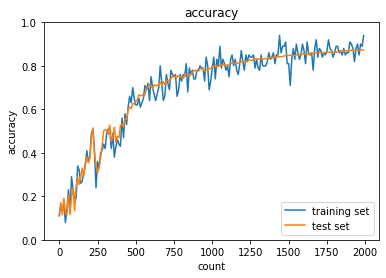

In [ ]:
# データの読み込み
(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True, one_hot_label=True)

print("データ読み込み完了")

network = MultiLayerNet(input_size=784, hidden_size_list=[40, 20], output_size=10, activation='sigmoid', weight_init_std='Xavier')

iters_num = 2000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval=10

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    # 勾配
    grad = network.gradient(x_batch, d_batch)
    
    for key in ('W1', 'W2', 'W3', 'b1', 'b2', 'b3'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, d_batch)
    train_loss_list.append(loss)
    
    if (i + 1) % plot_interval == 0:
        accr_test = network.accuracy(x_test, d_test)
        accuracies_test.append(accr_test)        
        accr_train = network.accuracy(x_batch, d_batch)
        accuracies_train.append(accr_train)
        
        print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
        print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))
        

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()

### ReLU-He

データ読み込み完了
Generation: 10. 正答率(トレーニング) = 0.37
                : 10. 正答率(テスト) = 0.3588
Generation: 20. 正答率(トレーニング) = 0.55
                : 20. 正答率(テスト) = 0.4356
Generation: 30. 正答率(トレーニング) = 0.57
                : 30. 正答率(テスト) = 0.581
Generation: 40. 正答率(トレーニング) = 0.7
                : 40. 正答率(テスト) = 0.6968
Generation: 50. 正答率(トレーニング) = 0.75
                : 50. 正答率(テスト) = 0.7348
Generation: 60. 正答率(トレーニング) = 0.78
                : 60. 正答率(テスト) = 0.7871
Generation: 70. 正答率(トレーニング) = 0.88
                : 70. 正答率(テスト) = 0.823
Generation: 80. 正答率(トレーニング) = 0.86
                : 80. 正答率(テスト) = 0.8394
Generation: 90. 正答率(トレーニング) = 0.85
                : 90. 正答率(テスト) = 0.8496
Generation: 100. 正答率(トレーニング) = 0.88
                : 100. 正答率(テスト) = 0.8542
Generation: 110. 正答率(トレーニング) = 0.93
                : 110. 正答率(テスト) = 0.8515
Generation: 120. 正答率(トレーニング) = 0.94
                : 120. 正答率(テスト) = 0.8672
Generation: 130. 正答率(トレーニング) = 0.92
                : 130. 正答率(テスト) = 0.8716
Generation

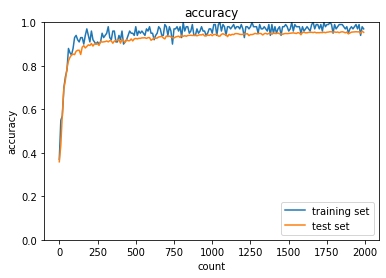

In [ ]:
# データの読み込み
(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True, one_hot_label=True)

print("データ読み込み完了")

network = MultiLayerNet(input_size=784, hidden_size_list=[40, 20], output_size=10, activation='relu', weight_init_std='He')

iters_num = 2000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval=10

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    # 勾配
    grad = network.gradient(x_batch, d_batch)
    
    for key in ('W1', 'W2', 'W3', 'b1', 'b2', 'b3'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, d_batch)
    train_loss_list.append(loss)
    
    if (i + 1) % plot_interval == 0:
        accr_test = network.accuracy(x_test, d_test)
        accuracies_test.append(accr_test)        
        accr_train = network.accuracy(x_batch, d_batch)
        accuracies_train.append(accr_train)
        
        print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
        print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))
        

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()

- 活性化関数と重み初期化方法の組み合わせで、学習速度が異なる
  - サンプル問題の場合
    - sigmoid-gaussだと学習できない 
    - ReLU-gauss, sigmoid-Xavier, ReLU-Heは80％以上の正解率まで学習できる
    - ReLU-gaussは最初にうまく学習できないケースが続く
    - sigmoid-Xavierは最初から学習が進んでいく
    - ReLU-Heは今回の組み合わせで最も速く学習できている

## [try] hidden_size_listの数字を変更してみよう

### ReLU-He

データ読み込み完了
Generation: 10. 正答率(トレーニング) = 0.31
                : 10. 正答率(テスト) = 0.2916
Generation: 20. 正答率(トレーニング) = 0.48
                : 20. 正答率(テスト) = 0.4695
Generation: 30. 正答率(トレーニング) = 0.48
                : 30. 正答率(テスト) = 0.4543
Generation: 40. 正答率(トレーニング) = 0.48
                : 40. 正答率(テスト) = 0.4265
Generation: 50. 正答率(トレーニング) = 0.8
                : 50. 正答率(テスト) = 0.7353
Generation: 60. 正答率(トレーニング) = 0.65
                : 60. 正答率(テスト) = 0.6702
Generation: 70. 正答率(トレーニング) = 0.83
                : 70. 正答率(テスト) = 0.8064
Generation: 80. 正答率(トレーニング) = 0.87
                : 80. 正答率(テスト) = 0.8121
Generation: 90. 正答率(トレーニング) = 0.91
                : 90. 正答率(テスト) = 0.8134
Generation: 100. 正答率(トレーニング) = 0.79
                : 100. 正答率(テスト) = 0.7933
Generation: 110. 正答率(トレーニング) = 0.84
                : 110. 正答率(テスト) = 0.7979
Generation: 120. 正答率(トレーニング) = 0.95
                : 120. 正答率(テスト) = 0.8714
Generation: 130. 正答率(トレーニング) = 0.87
                : 130. 正答率(テスト) = 0.8646
Generati

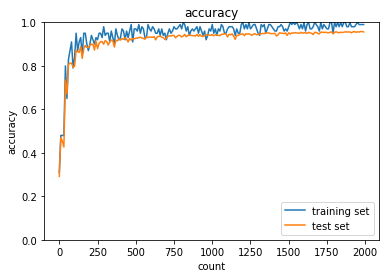

In [ ]:
# データの読み込み
(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True, one_hot_label=True)

print("データ読み込み完了")

network = MultiLayerNet(input_size=784, hidden_size_list=[40, 30, 20], output_size=10, activation='relu', weight_init_std='He')

iters_num = 2000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval=10

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    # 勾配
    grad = network.gradient(x_batch, d_batch)
    
    for key in ('W1', 'W2', 'W3', 'b1', 'b2', 'b3'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, d_batch)
    train_loss_list.append(loss)
    
    if (i + 1) % plot_interval == 0:
        accr_test = network.accuracy(x_test, d_test)
        accuracies_test.append(accr_test)        
        accr_train = network.accuracy(x_batch, d_batch)
        accuracies_train.append(accr_train)
        
        print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
        print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))
        

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()

- 中間層を中間層を3層にして、ノードを[40, 30, 20]とすると、学習の速さと正答率が向上する

## [try] sigmoid - He と relu - Xavier についても試してみよう

### sigmoid - He

データ読み込み完了
Generation: 10. 正答率(トレーニング) = 0.13
                : 10. 正答率(テスト) = 0.1132
Generation: 20. 正答率(トレーニング) = 0.13
                : 20. 正答率(テスト) = 0.1635
Generation: 30. 正答率(トレーニング) = 0.26
                : 30. 正答率(テスト) = 0.223
Generation: 40. 正答率(トレーニング) = 0.25
                : 40. 正答率(テスト) = 0.2554
Generation: 50. 正答率(トレーニング) = 0.33
                : 50. 正答率(テスト) = 0.2457
Generation: 60. 正答率(トレーニング) = 0.39
                : 60. 正答率(テスト) = 0.3744
Generation: 70. 正答率(トレーニング) = 0.38
                : 70. 正答率(テスト) = 0.3763
Generation: 80. 正答率(トレーニング) = 0.37
                : 80. 正答率(テスト) = 0.3545
Generation: 90. 正答率(トレーニング) = 0.28
                : 90. 正答率(テスト) = 0.4012
Generation: 100. 正答率(トレーニング) = 0.38
                : 100. 正答率(テスト) = 0.4397
Generation: 110. 正答率(トレーニング) = 0.49
                : 110. 正答率(テスト) = 0.5041
Generation: 120. 正答率(トレーニング) = 0.54
                : 120. 正答率(テスト) = 0.4667
Generation: 130. 正答率(トレーニング) = 0.55
                : 130. 正答率(テスト) = 0.4815
Generati

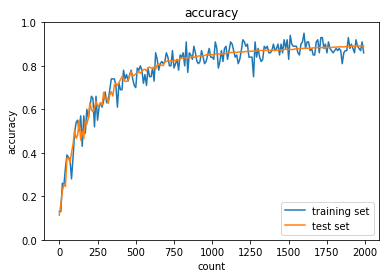

In [ ]:
# データの読み込み
(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True, one_hot_label=True)

print("データ読み込み完了")

network = MultiLayerNet(input_size=784, hidden_size_list=[40, 20], output_size=10, activation='sigmoid', weight_init_std="He")

iters_num = 2000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval=10

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    # 勾配
    grad = network.gradient(x_batch, d_batch)
    
    for key in ('W1', 'W2', 'W3', 'b1', 'b2', 'b3'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, d_batch)
    train_loss_list.append(loss)
    
    if (i + 1) % plot_interval == 0:
        accr_test = network.accuracy(x_test, d_test)
        accuracies_test.append(accr_test)        
        accr_train = network.accuracy(x_batch, d_batch)
        accuracies_train.append(accr_train)
        
        print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
        print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))
        

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()

- sigmoid - gaussのケースより、正答率が50%以上向上する

### ReLU - Xavier

データ読み込み完了
Generation: 10. 正答率(トレーニング) = 0.1
                : 10. 正答率(テスト) = 0.1528
Generation: 20. 正答率(トレーニング) = 0.27
                : 20. 正答率(テスト) = 0.2074
Generation: 30. 正答率(トレーニング) = 0.23
                : 30. 正答率(テスト) = 0.2707
Generation: 40. 正答率(トレーニング) = 0.24
                : 40. 正答率(テスト) = 0.2764
Generation: 50. 正答率(トレーニング) = 0.45
                : 50. 正答率(テスト) = 0.3903
Generation: 60. 正答率(トレーニング) = 0.39
                : 60. 正答率(テスト) = 0.4278
Generation: 70. 正答率(トレーニング) = 0.51
                : 70. 正答率(テスト) = 0.4725
Generation: 80. 正答率(トレーニング) = 0.57
                : 80. 正答率(テスト) = 0.5602
Generation: 90. 正答率(トレーニング) = 0.57
                : 90. 正答率(テスト) = 0.5779
Generation: 100. 正答率(トレーニング) = 0.7
                : 100. 正答率(テスト) = 0.6135
Generation: 110. 正答率(トレーニング) = 0.63
                : 110. 正答率(テスト) = 0.5875
Generation: 120. 正答率(トレーニング) = 0.67
                : 120. 正答率(テスト) = 0.6738
Generation: 130. 正答率(トレーニング) = 0.81
                : 130. 正答率(テスト) = 0.7256
Generatio

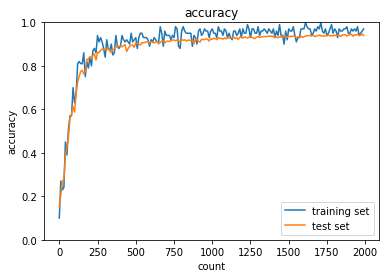

In [ ]:
# データの読み込み
(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True, one_hot_label=True)

print("データ読み込み完了")

network = MultiLayerNet(input_size=784, hidden_size_list=[40, 30, 20], output_size=10, activation='relu', weight_init_std='Xavier')

iters_num = 2000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval=10

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    # 勾配
    grad = network.gradient(x_batch, d_batch)
    
    for key in ('W1', 'W2', 'W3', 'b1', 'b2', 'b3'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, d_batch)
    train_loss_list.append(loss)
    
    if (i + 1) % plot_interval == 0:
        accr_test = network.accuracy(x_test, d_test)
        accuracies_test.append(accr_test)        
        accr_train = network.accuracy(x_batch, d_batch)
        accuracies_train.append(accr_train)
        
        print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
        print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))
        

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()

- ReLU -Heのケースと差異は見えない

## バッチ正規化

In [ ]:
# バッチ正則化 layer
class BatchNormalization:
    '''
    gamma: スケール係数
    beta: オフセット
    momentum: 慣性
    running_mean: テスト時に使用する平均
    running_var: テスト時に使用する分散
    '''
    def __init__(self, gamma, beta, momentum=0.9, running_mean=None, running_var=None):
        self.gamma = gamma
        self.beta = beta
        self.momentum = momentum
        self.input_shape = None

        self.running_mean = running_mean
        self.running_var = running_var  
        
        # backward時に使用する中間データ
        self.batch_size = None
        self.xc = None
        self.std = None
        self.dgamma = None
        self.dbeta = None

    def forward(self, x, train_flg=True):
        if self.running_mean is None:
            N, D = x.shape
            self.running_mean = np.zeros(D)
            self.running_var = np.zeros(D)
                        
        if train_flg:
            mu = x.mean(axis=0) # 平均
            xc = x - mu # xをセンタリング
            var = np.mean(xc**2, axis=0) # 分散
            std = np.sqrt(var + 10e-7) # スケーリング
            xn = xc / std
            
            self.batch_size = x.shape[0]
            self.xc = xc
            self.xn = xn
            self.std = std
            self.running_mean = self.momentum * self.running_mean + (1-self.momentum) * mu # 平均値の加重平均
            self.running_var = self.momentum * self.running_var + (1-self.momentum) * var #分散値の加重平均
        else:
            xc = x - self.running_mean
            xn = xc / ((np.sqrt(self.running_var + 10e-7)))
            
        out = self.gamma * xn + self.beta 
        
        return out

    def backward(self, dout):
        dbeta = dout.sum(axis=0)
        dgamma = np.sum(self.xn * dout, axis=0)
        dxn = self.gamma * dout
        dxc = dxn / self.std
        dstd = -np.sum((dxn * self.xc) / (self.std * self.std), axis=0)
        dvar = 0.5 * dstd / self.std
        dxc += (2.0 / self.batch_size) * self.xc * dvar
        dmu = np.sum(dxc, axis=0)
        dx = dxc - dmu / self.batch_size
        
        self.dgamma = dgamma
        self.dbeta = dbeta

        return dx    


データ読み込み完了
Generation: 10. 正答率(トレーニング) = 0.06
                : 10. 正答率(テスト) = 0.1029
Generation: 20. 正答率(トレーニング) = 0.13
                : 20. 正答率(テスト) = 0.1194
Generation: 30. 正答率(トレーニング) = 0.11
                : 30. 正答率(テスト) = 0.1403
Generation: 40. 正答率(トレーニング) = 0.23
                : 40. 正答率(テスト) = 0.1763
Generation: 50. 正答率(トレーニング) = 0.21
                : 50. 正答率(テスト) = 0.2137
Generation: 60. 正答率(トレーニング) = 0.25
                : 60. 正答率(テスト) = 0.2496
Generation: 70. 正答率(トレーニング) = 0.34
                : 70. 正答率(テスト) = 0.2805
Generation: 80. 正答率(トレーニング) = 0.33
                : 80. 正答率(テスト) = 0.3015
Generation: 90. 正答率(トレーニング) = 0.34
                : 90. 正答率(テスト) = 0.3191
Generation: 100. 正答率(トレーニング) = 0.43
                : 100. 正答率(テスト) = 0.3367
Generation: 110. 正答率(トレーニング) = 0.43
                : 110. 正答率(テスト) = 0.3591
Generation: 120. 正答率(トレーニング) = 0.3
                : 120. 正答率(テスト) = 0.3698
Generation: 130. 正答率(トレーニング) = 0.35
                : 130. 正答率(テスト) = 0.395
Generatio

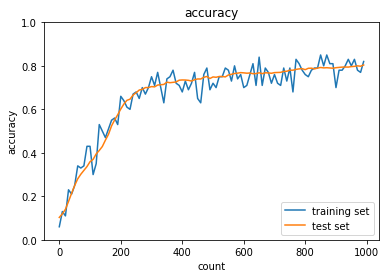

In [ ]:
(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True)

print("データ読み込み完了")


# batch_normalizationの設定 =======================
use_batchnorm = True
# use_batchnorm = False
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[40, 20], output_size=10,
                        activation='sigmoid', weight_init_std='Xavier', use_batchnorm=use_batchnorm)

iters_num = 1000
train_size = x_train.shape[0]
batch_size = 100
learning_rate=0.01

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval=10


for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    grad = network.gradient(x_batch, d_batch)
    for key in ('W1', 'W2', 'W3', 'b1', 'b2', 'b3'):
        network.params[key] -= learning_rate * grad[key]

        loss = network.loss(x_batch, d_batch)
        train_loss_list.append(loss)        
        
    if (i + 1) % plot_interval == 0:
        accr_test = network.accuracy(x_test, d_test)
        accuracies_test.append(accr_test)        
        accr_train = network.accuracy(x_batch, d_batch)
        accuracies_train.append(accr_train)
        
        print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
        print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))
                

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()

### 例題チャレンジ

　ループの回数が回数がi番目、バッチサイズがbatch_sizeのとき、data_xととdata_tから今回のバッチ学習用データを抜き取るコードは?

- data_x[i:batch_size]とdata_t[i:batch_size]

## [try] 活性化関数や重みの初期値を変えてみよう

### 活性化関数をReLU

データ読み込み完了
Generation: 10. 正答率(トレーニング) = 0.26
                : 10. 正答率(テスト) = 0.2506
Generation: 20. 正答率(トレーニング) = 0.35
                : 20. 正答率(テスト) = 0.3708
Generation: 30. 正答率(トレーニング) = 0.53
                : 30. 正答率(テスト) = 0.4433
Generation: 40. 正答率(トレーニング) = 0.43
                : 40. 正答率(テスト) = 0.4951
Generation: 50. 正答率(トレーニング) = 0.51
                : 50. 正答率(テスト) = 0.5354
Generation: 60. 正答率(トレーニング) = 0.61
                : 60. 正答率(テスト) = 0.5672
Generation: 70. 正答率(トレーニング) = 0.64
                : 70. 正答率(テスト) = 0.5993
Generation: 80. 正答率(トレーニング) = 0.66
                : 80. 正答率(テスト) = 0.6239
Generation: 90. 正答率(トレーニング) = 0.64
                : 90. 正答率(テスト) = 0.6445
Generation: 100. 正答率(トレーニング) = 0.63
                : 100. 正答率(テスト) = 0.6698
Generation: 110. 正答率(トレーニング) = 0.66
                : 110. 正答率(テスト) = 0.6914
Generation: 120. 正答率(トレーニング) = 0.66
                : 120. 正答率(テスト) = 0.7094
Generation: 130. 正答率(トレーニング) = 0.7
                : 130. 正答率(テスト) = 0.7223
Generati

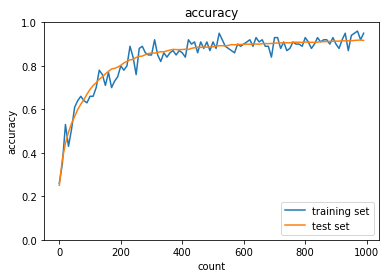

In [ ]:
(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True)

print("データ読み込み完了")


# batch_normalizationの設定 =======================
use_batchnorm = True
# use_batchnorm = False
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[40, 20], output_size=10,
                        activation='relu', weight_init_std='Xavier', use_batchnorm=use_batchnorm)

iters_num = 1000
train_size = x_train.shape[0]
batch_size = 100
learning_rate=0.01

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval=10


for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    grad = network.gradient(x_batch, d_batch)
    for key in ('W1', 'W2', 'W3', 'b1', 'b2', 'b3'):
        network.params[key] -= learning_rate * grad[key]

        loss = network.loss(x_batch, d_batch)
        train_loss_list.append(loss)        
        
    if (i + 1) % plot_interval == 0:
        accr_test = network.accuracy(x_test, d_test)
        accuracies_test.append(accr_test)        
        accr_train = network.accuracy(x_batch, d_batch)
        accuracies_train.append(accr_train)
        
        print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
        print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))
                

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()

- sigmoidのケースより、正答率が向上している

### 重みの初期化を初期化をHe

データ読み込み完了
Generation: 10. 正答率(トレーニング) = 0.15
                : 10. 正答率(テスト) = 0.1124
Generation: 20. 正答率(トレーニング) = 0.11
                : 20. 正答率(テスト) = 0.1286
Generation: 30. 正答率(トレーニング) = 0.15
                : 30. 正答率(テスト) = 0.1661
Generation: 40. 正答率(トレーニング) = 0.24
                : 40. 正答率(テスト) = 0.2171
Generation: 50. 正答率(トレーニング) = 0.29
                : 50. 正答率(テスト) = 0.2629
Generation: 60. 正答率(トレーニング) = 0.23
                : 60. 正答率(テスト) = 0.3092
Generation: 70. 正答率(トレーニング) = 0.35
                : 70. 正答率(テスト) = 0.3463
Generation: 80. 正答率(トレーニング) = 0.35
                : 80. 正答率(テスト) = 0.3785
Generation: 90. 正答率(トレーニング) = 0.4
                : 90. 正答率(テスト) = 0.4049
Generation: 100. 正答率(トレーニング) = 0.42
                : 100. 正答率(テスト) = 0.4224
Generation: 110. 正答率(トレーニング) = 0.45
                : 110. 正答率(テスト) = 0.4379
Generation: 120. 正答率(トレーニング) = 0.45
                : 120. 正答率(テスト) = 0.448
Generation: 130. 正答率(トレーニング) = 0.45
                : 130. 正答率(テスト) = 0.4608
Generatio

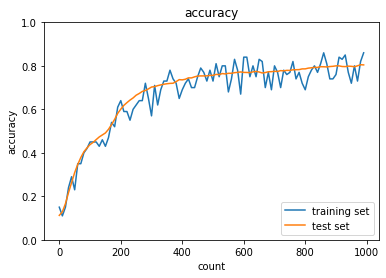

In [ ]:
(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True)

print("データ読み込み完了")


# batch_normalizationの設定 =======================
use_batchnorm = True
# use_batchnorm = False
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[40, 20], output_size=10,
                        activation='sigmoid', weight_init_std='He', use_batchnorm=use_batchnorm)

iters_num = 1000
train_size = x_train.shape[0]
batch_size = 100
learning_rate=0.01

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval=10


for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    grad = network.gradient(x_batch, d_batch)
    for key in ('W1', 'W2', 'W3', 'b1', 'b2', 'b3'):
        network.params[key] -= learning_rate * grad[key]

        loss = network.loss(x_batch, d_batch)
        train_loss_list.append(loss)        
        
    if (i + 1) % plot_interval == 0:
        accr_test = network.accuracy(x_test, d_test)
        accuracies_test.append(accr_test)        
        accr_train = network.accuracy(x_batch, d_batch)
        accuracies_train.append(accr_train)
        
        print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
        print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))
                

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()

- Xavierのケースより、学習の速度が遅い

# Section2: 学習率最適化手法

## 要点のまとめ

- モメンタム、AdaGrad、RMSProp、Adamなどがある。モメンタムの「過去の勾配の指数関数的減衰」ととRMSPropの「過去の勾配の2乗の指数関数的減衰」というメリットを組み合わせるAdamが学習率最適化手法としてよく使われる

## 確認テスト

モメンタム、AdaGrad、RMSPropの特徴を説明せよ

- モメンタム

  - 前回の重み更新量に慣性を乗算し、誤差のパラメータ微分値に学習率を乗算したものを減算して、重みを更新
  - 大域的最適解になる
  - 最適値に収束する時間が短い

- AdaGrad

  - 誤差をパラメータで微分したものと再定義した学習率の積を減算する
  - 勾配の緩やかな斜面に対して、最適解に近づける
  - 学習率が徐々に小さくなるので、鞍点問題を引き起こす

- RMSProp

  - 誤差をパラメータで微分したものと再定義した学習率の積を減算する
  - 大域的最適解になる
  - ハイパーパラメータの調整が必要な場合が少ない

## SGD

データ読み込み完了
Generation: 10. 正答率(トレーニング) = 0.13
                : 10. 正答率(テスト) = 0.0982
Generation: 20. 正答率(トレーニング) = 0.08
                : 20. 正答率(テスト) = 0.0982
Generation: 30. 正答率(トレーニング) = 0.1
                : 30. 正答率(テスト) = 0.0982
Generation: 40. 正答率(トレーニング) = 0.1
                : 40. 正答率(テスト) = 0.0982
Generation: 50. 正答率(トレーニング) = 0.08
                : 50. 正答率(テスト) = 0.0982
Generation: 60. 正答率(トレーニング) = 0.08
                : 60. 正答率(テスト) = 0.1135
Generation: 70. 正答率(トレーニング) = 0.12
                : 70. 正答率(テスト) = 0.1135
Generation: 80. 正答率(トレーニング) = 0.09
                : 80. 正答率(テスト) = 0.1135
Generation: 90. 正答率(トレーニング) = 0.19
                : 90. 正答率(テスト) = 0.1135
Generation: 100. 正答率(トレーニング) = 0.06
                : 100. 正答率(テスト) = 0.1135
Generation: 110. 正答率(トレーニング) = 0.1
                : 110. 正答率(テスト) = 0.1135
Generation: 120. 正答率(トレーニング) = 0.14
                : 120. 正答率(テスト) = 0.1135
Generation: 130. 正答率(トレーニング) = 0.12
                : 130. 正答率(テスト) = 0.1135
Generation

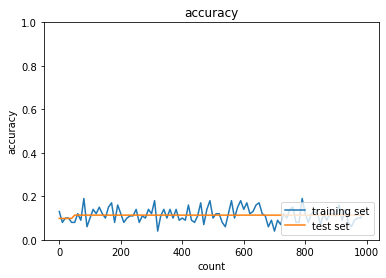

In [ ]:
# データの読み込み
(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True, one_hot_label=True)

print("データ読み込み完了")

# batch_normalizationの設定 ================================
# use_batchnorm = True
use_batchnorm = False
# ====================================================


network = MultiLayerNet(input_size=784, hidden_size_list=[40, 20], output_size=10, activation='sigmoid', weight_init_std=0.01,
                       use_batchnorm=use_batchnorm)

iters_num = 1000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval=10

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    # 勾配
    grad = network.gradient(x_batch, d_batch)
    
    for key in ('W1', 'W2', 'W3', 'b1', 'b2', 'b3'):
        network.params[key] -= learning_rate * grad[key]
        
        loss = network.loss(x_batch, d_batch)
        train_loss_list.append(loss)
    
    
    if (i + 1) % plot_interval == 0:
        accr_test = network.accuracy(x_test, d_test)
        accuracies_test.append(accr_test)        
        accr_train = network.accuracy(x_batch, d_batch)
        accuracies_train.append(accr_train)
        
        print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
        print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))

        
lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()

## モーメンタム

データ読み込み完了
Generation: 10. 正答率(トレーニング) = 0.08
                : 10. 正答率(テスト) = 0.1032
Generation: 20. 正答率(トレーニング) = 0.11
                : 20. 正答率(テスト) = 0.1032
Generation: 30. 正答率(トレーニング) = 0.09
                : 30. 正答率(テスト) = 0.1028
Generation: 40. 正答率(トレーニング) = 0.06
                : 40. 正答率(テスト) = 0.098
Generation: 50. 正答率(トレーニング) = 0.11
                : 50. 正答率(テスト) = 0.098
Generation: 60. 正答率(トレーニング) = 0.08
                : 60. 正答率(テスト) = 0.098
Generation: 70. 正答率(トレーニング) = 0.05
                : 70. 正答率(テスト) = 0.1135
Generation: 80. 正答率(トレーニング) = 0.14
                : 80. 正答率(テスト) = 0.1028
Generation: 90. 正答率(トレーニング) = 0.1
                : 90. 正答率(テスト) = 0.1028
Generation: 100. 正答率(トレーニング) = 0.08
                : 100. 正答率(テスト) = 0.1028
Generation: 110. 正答率(トレーニング) = 0.11
                : 110. 正答率(テスト) = 0.1135
Generation: 120. 正答率(トレーニング) = 0.18
                : 120. 正答率(テスト) = 0.1135
Generation: 130. 正答率(トレーニング) = 0.07
                : 130. 正答率(テスト) = 0.1135
Generation:

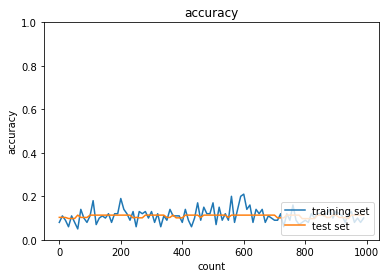

In [ ]:
# データの読み込み
(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True, one_hot_label=True)

print("データ読み込み完了")

# batch_normalizationの設定 ================================
# use_batchnorm = True
use_batchnorm = False
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[40, 20], output_size=10, activation='sigmoid', weight_init_std=0.01,
                       use_batchnorm=use_batchnorm)

iters_num = 1000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01
# 慣性
momentum = 0.9

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval=10

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    # 勾配
    grad = network.gradient(x_batch, d_batch)
    if i == 0:
        v = {}
    for key in ('W1', 'W2', 'W3', 'b1', 'b2', 'b3'):
        if i == 0:
            v[key] = np.zeros_like(network.params[key])
        v[key] = momentum * v[key] - learning_rate * grad[key]
        network.params[key] += v[key]

        loss = network.loss(x_batch, d_batch)
        train_loss_list.append(loss)
        
    if (i + 1) % plot_interval == 0:
        accr_test = network.accuracy(x_test, d_test)
        accuracies_test.append(accr_test)        
        accr_train = network.accuracy(x_batch, d_batch)
        accuracies_train.append(accr_train)

        print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
        print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))
        
        
lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()

## モーメンタムをもとにAdaGradを作る

θ=1e-4

データ読み込み完了
Generation: 10. 正答率(トレーニング) = 0.09
                : 10. 正答率(テスト) = 0.1135
Generation: 20. 正答率(トレーニング) = 0.08
                : 20. 正答率(テスト) = 0.1135
Generation: 30. 正答率(トレーニング) = 0.09
                : 30. 正答率(テスト) = 0.1135
Generation: 40. 正答率(トレーニング) = 0.12
                : 40. 正答率(テスト) = 0.1135
Generation: 50. 正答率(トレーニング) = 0.13
                : 50. 正答率(テスト) = 0.1135
Generation: 60. 正答率(トレーニング) = 0.11
                : 60. 正答率(テスト) = 0.1135
Generation: 70. 正答率(トレーニング) = 0.12
                : 70. 正答率(テスト) = 0.1135
Generation: 80. 正答率(トレーニング) = 0.11
                : 80. 正答率(テスト) = 0.1135
Generation: 90. 正答率(トレーニング) = 0.12
                : 90. 正答率(テスト) = 0.1135
Generation: 100. 正答率(トレーニング) = 0.11
                : 100. 正答率(テスト) = 0.1135
Generation: 110. 正答率(トレーニング) = 0.06
                : 110. 正答率(テスト) = 0.1135
Generation: 120. 正答率(トレーニング) = 0.09
                : 120. 正答率(テスト) = 0.1135
Generation: 130. 正答率(トレーニング) = 0.18
                : 130. 正答率(テスト) = 0.1135
Generat

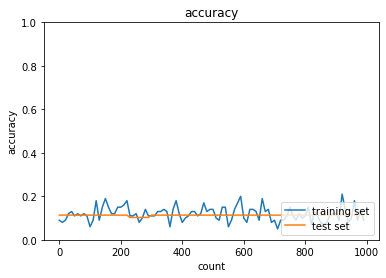

In [ ]:
# AdaGradを作ってみよう
# データの読み込み
(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True, one_hot_label=True)

print("データ読み込み完了")

# batch_normalizationの設定 ================================
# use_batchnorm = True
use_batchnorm = False
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[40, 20], output_size=10, activation='sigmoid', weight_init_std=0.01,
                       use_batchnorm=use_batchnorm)

iters_num = 1000
# iters_num = 500 # 処理を短縮

train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01

# AdaGradでは不必要
# =============================

#momentum = 0.9 

# =============================

theta = 1e-4

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval=10

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    # 勾配
    grad = network.gradient(x_batch, d_batch)
    if i == 0:
        h = {}
    for key in ('W1', 'W2', 'W3', 'b1', 'b2', 'b3'):
            
        # 変更しよう  
        # ===========================================
        if i == 0:
            #h[key] = np.zeros_like(network.params[key])
            h[key] = theta 
        #h[key] = momentum * h[key] - learning_rate * grad[key]
        h[key] = h[key] + grad[key] ** 2
        #network.params[key] += h[key]
        network.params[key] += - learning_rate * grad[key] / (np.sqrt(h[key]) + theta)

        # ===========================================
        
        loss = network.loss(x_batch, d_batch)
        train_loss_list.append(loss)
        
    if (i + 1) % plot_interval == 0:
        accr_test = network.accuracy(x_test, d_test)
        accuracies_test.append(accr_test)        
        accr_train = network.accuracy(x_batch, d_batch)
        accuracies_train.append(accr_train)

        print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
        print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))
        
        
lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()

## RMSProp

データ読み込み完了
Generation: 10. 正答率(トレーニング) = 0.2
                : 10. 正答率(テスト) = 0.1862
Generation: 20. 正答率(トレーニング) = 0.23
                : 20. 正答率(テスト) = 0.2089
Generation: 30. 正答率(トレーニング) = 0.27
                : 30. 正答率(テスト) = 0.2305
Generation: 40. 正答率(トレーニング) = 0.29
                : 40. 正答率(テスト) = 0.2716
Generation: 50. 正答率(トレーニング) = 0.36
                : 50. 正答率(テスト) = 0.275
Generation: 60. 正答率(トレーニング) = 0.48
                : 60. 正答率(テスト) = 0.4206
Generation: 70. 正答率(トレーニング) = 0.48
                : 70. 正答率(テスト) = 0.3937
Generation: 80. 正答率(トレーニング) = 0.51
                : 80. 正答率(テスト) = 0.4713
Generation: 90. 正答率(トレーニング) = 0.56
                : 90. 正答率(テスト) = 0.5288
Generation: 100. 正答率(トレーニング) = 0.56
                : 100. 正答率(テスト) = 0.5021
Generation: 110. 正答率(トレーニング) = 0.68
                : 110. 正答率(テスト) = 0.5412
Generation: 120. 正答率(トレーニング) = 0.6
                : 120. 正答率(テスト) = 0.5726
Generation: 130. 正答率(トレーニング) = 0.61
                : 130. 正答率(テスト) = 0.6162
Generation

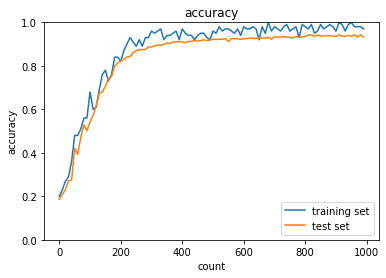

In [ ]:
# データの読み込み
(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True, one_hot_label=True)

print("データ読み込み完了")

# batch_normalizationの設定 ================================
# use_batchnorm = True
use_batchnorm = False
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[40, 20], output_size=10, activation='sigmoid', weight_init_std=0.01,
                       use_batchnorm=use_batchnorm)

iters_num = 1000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01
decay_rate = 0.99

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval=10

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    # 勾配
    grad = network.gradient(x_batch, d_batch)
    if i == 0:
        h = {}
    for key in ('W1', 'W2', 'W3', 'b1', 'b2', 'b3'):
        if i == 0:
            h[key] = np.zeros_like(network.params[key])
        h[key] *= decay_rate
        h[key] += (1 - decay_rate) * np.square(grad[key])
        network.params[key] -= learning_rate * grad[key] / (np.sqrt(h[key]) + 1e-7)

        loss = network.loss(x_batch, d_batch)
        train_loss_list.append(loss)                
        
    if (i + 1) % plot_interval == 0:
        accr_test = network.accuracy(x_test, d_test)
        accuracies_test.append(accr_test)        
        accr_train = network.accuracy(x_batch, d_batch)
        accuracies_train.append(accr_train)
        
        print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
        print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))
        
        
lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()

## Adam

データ読み込み完了
Generation: 10. 正答率(トレーニング) = 0.06
                : 10. 正答率(テスト) = 0.1135
Generation: 20. 正答率(トレーニング) = 0.09
                : 20. 正答率(テスト) = 0.1135
Generation: 30. 正答率(トレーニング) = 0.2
                : 30. 正答率(テスト) = 0.237
Generation: 40. 正答率(トレーニング) = 0.17
                : 40. 正答率(テスト) = 0.179
Generation: 50. 正答率(トレーニング) = 0.34
                : 50. 正答率(テスト) = 0.3142
Generation: 60. 正答率(トレーニング) = 0.27
                : 60. 正答率(テスト) = 0.3255
Generation: 70. 正答率(トレーニング) = 0.36
                : 70. 正答率(テスト) = 0.4036
Generation: 80. 正答率(トレーニング) = 0.42
                : 80. 正答率(テスト) = 0.4187
Generation: 90. 正答率(トレーニング) = 0.51
                : 90. 正答率(テスト) = 0.4742
Generation: 100. 正答率(トレーニング) = 0.46
                : 100. 正答率(テスト) = 0.4783
Generation: 110. 正答率(トレーニング) = 0.53
                : 110. 正答率(テスト) = 0.4917
Generation: 120. 正答率(トレーニング) = 0.48
                : 120. 正答率(テスト) = 0.4761
Generation: 130. 正答率(トレーニング) = 0.53
                : 130. 正答率(テスト) = 0.5494
Generation

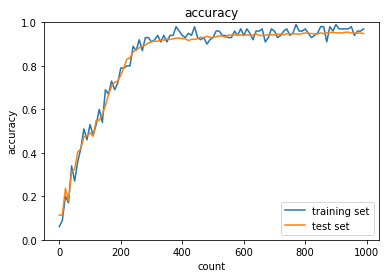

In [ ]:
# データの読み込み
(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True, one_hot_label=True)

print("データ読み込み完了")

# batch_normalizationの設定 ================================
# use_batchnorm = True
use_batchnorm = False
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[40, 20], output_size=10, activation='sigmoid', weight_init_std=0.01,
                       use_batchnorm=use_batchnorm)

iters_num = 1000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01
beta1 = 0.9
beta2 = 0.999

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval=10

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    # 勾配
    grad = network.gradient(x_batch, d_batch)
    if i == 0:
        m = {}
        v = {}
    learning_rate_t  = learning_rate * np.sqrt(1.0 - beta2 ** (i + 1)) / (1.0 - beta1 ** (i + 1))    
    for key in ('W1', 'W2', 'W3', 'b1', 'b2', 'b3'):
        if i == 0:
            m[key] = np.zeros_like(network.params[key])
            v[key] = np.zeros_like(network.params[key])
            
        m[key] += (1 - beta1) * (grad[key] - m[key])
        v[key] += (1 - beta2) * (grad[key] ** 2 - v[key])            
        network.params[key] -= learning_rate_t * m[key] / (np.sqrt(v[key]) + 1e-7)                
        
        
    if (i + 1) % plot_interval == 0:
        accr_test = network.accuracy(x_test, d_test)
        accuracies_test.append(accr_test)        
        accr_train = network.accuracy(x_batch, d_batch)
        accuracies_train.append(accr_train)
        loss = network.loss(x_batch, d_batch)
        train_loss_list.append(loss)        
        
        print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
        print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))
                

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()

## [try] 学習率を変えてみよう

データ読み込み完了
Generation: 10. 正答率(トレーニング) = 0.11
                : 10. 正答率(テスト) = 0.101
Generation: 20. 正答率(トレーニング) = 0.13
                : 20. 正答率(テスト) = 0.101
Generation: 30. 正答率(トレーニング) = 0.19
                : 30. 正答率(テスト) = 0.1028
Generation: 40. 正答率(トレーニング) = 0.15
                : 40. 正答率(テスト) = 0.0892
Generation: 50. 正答率(トレーニング) = 0.19
                : 50. 正答率(テスト) = 0.1135
Generation: 60. 正答率(トレーニング) = 0.13
                : 60. 正答率(テスト) = 0.1135
Generation: 70. 正答率(トレーニング) = 0.13
                : 70. 正答率(テスト) = 0.101
Generation: 80. 正答率(トレーニング) = 0.13
                : 80. 正答率(テスト) = 0.1028
Generation: 90. 正答率(トレーニング) = 0.17
                : 90. 正答率(テスト) = 0.0982
Generation: 100. 正答率(トレーニング) = 0.12
                : 100. 正答率(テスト) = 0.1009
Generation: 110. 正答率(トレーニング) = 0.13
                : 110. 正答率(テスト) = 0.1009
Generation: 120. 正答率(トレーニング) = 0.2
                : 120. 正答率(テスト) = 0.1032
Generation: 130. 正答率(トレーニング) = 0.16
                : 130. 正答率(テスト) = 0.098
Generation: 

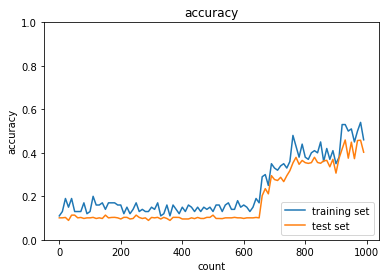

In [ ]:
# データの読み込み
(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True, one_hot_label=True)

print("データ読み込み完了")

# batch_normalizationの設定 ================================
# use_batchnorm = True
use_batchnorm = False
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[40, 20], output_size=10, activation='sigmoid', weight_init_std=0.01,
                       use_batchnorm=use_batchnorm)

iters_num = 1000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1
decay_rate = 0.99

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval=10

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    # 勾配
    grad = network.gradient(x_batch, d_batch)
    if i == 0:
        h = {}
    for key in ('W1', 'W2', 'W3', 'b1', 'b2', 'b3'):
        if i == 0:
            h[key] = np.zeros_like(network.params[key])
        h[key] *= decay_rate
        h[key] += (1 - decay_rate) * np.square(grad[key])
        network.params[key] -= learning_rate * grad[key] / (np.sqrt(h[key]) + 1e-7)

        loss = network.loss(x_batch, d_batch)
        train_loss_list.append(loss)                
        
    if (i + 1) % plot_interval == 0:
        accr_test = network.accuracy(x_test, d_test)
        accuracies_test.append(accr_test)        
        accr_train = network.accuracy(x_batch, d_batch)
        accuracies_train.append(accr_train)
        
        print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
        print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))
        
        
lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()

- RMSPropで、学習率がが0.01のときはうまく学習していたが、いたが、0.1にすると局所解にたどり着けなくなっている

## [try] 活性化関数と重みの初期化方法を変えてみよう

データ読み込み完了
Generation: 10. 正答率(トレーニング) = 0.21
                : 10. 正答率(テスト) = 0.1981
Generation: 20. 正答率(トレーニング) = 0.37
                : 20. 正答率(テスト) = 0.3038
Generation: 30. 正答率(トレーニング) = 0.4
                : 30. 正答率(テスト) = 0.3942
Generation: 40. 正答率(トレーニング) = 0.5
                : 40. 正答率(テスト) = 0.5729
Generation: 50. 正答率(トレーニング) = 0.62
                : 50. 正答率(テスト) = 0.6531
Generation: 60. 正答率(トレーニング) = 0.73
                : 60. 正答率(テスト) = 0.7675
Generation: 70. 正答率(トレーニング) = 0.78
                : 70. 正答率(テスト) = 0.7912
Generation: 80. 正答率(トレーニング) = 0.8
                : 80. 正答率(テスト) = 0.8167
Generation: 90. 正答率(トレーニング) = 0.84
                : 90. 正答率(テスト) = 0.8367
Generation: 100. 正答率(トレーニング) = 0.83
                : 100. 正答率(テスト) = 0.848
Generation: 110. 正答率(トレーニング) = 0.9
                : 110. 正答率(テスト) = 0.8628
Generation: 120. 正答率(トレーニング) = 0.91
                : 120. 正答率(テスト) = 0.8643
Generation: 130. 正答率(トレーニング) = 0.88
                : 130. 正答率(テスト) = 0.8641
Generation: 

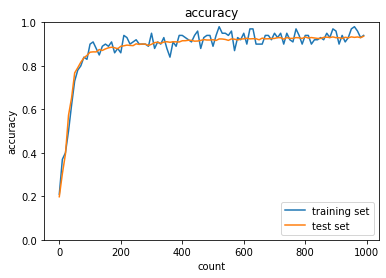

In [ ]:
# データの読み込み
(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True, one_hot_label=True)

print("データ読み込み完了")

# batch_normalizationの設定 ================================
# use_batchnorm = True
use_batchnorm = False
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[40, 20], output_size=10, activation='relu', weight_init_std="Xavier",
                       use_batchnorm=use_batchnorm)

iters_num = 1000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01
# 慣性
momentum = 0.9

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval=10

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    # 勾配
    grad = network.gradient(x_batch, d_batch)
    if i == 0:
        v = {}
    for key in ('W1', 'W2', 'W3', 'b1', 'b2', 'b3'):
        if i == 0:
            v[key] = np.zeros_like(network.params[key])
        v[key] = momentum * v[key] - learning_rate * grad[key]
        network.params[key] += v[key]

        loss = network.loss(x_batch, d_batch)
        train_loss_list.append(loss)
        
    if (i + 1) % plot_interval == 0:
        accr_test = network.accuracy(x_test, d_test)
        accuracies_test.append(accr_test)        
        accr_train = network.accuracy(x_batch, d_batch)
        accuracies_train.append(accr_train)

        print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
        print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))
        
        
lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()

- モーメンタムで、、sigmoid - gaussで学習できていなかったが、学習できていなかったが、ReLU - Xavierだと正答率が正答率が90%以上まで学習が進む

## [try] バッチ正規化をしてみよう

データ読み込み完了
Generation: 10. 正答率(トレーニング) = 0.23
                : 10. 正答率(テスト) = 0.287
Generation: 20. 正答率(トレーニング) = 0.5
                : 20. 正答率(テスト) = 0.4838
Generation: 30. 正答率(トレーニング) = 0.7
                : 30. 正答率(テスト) = 0.6998
Generation: 40. 正答率(トレーニング) = 0.83
                : 40. 正答率(テスト) = 0.7555
Generation: 50. 正答率(トレーニング) = 0.76
                : 50. 正答率(テスト) = 0.7159
Generation: 60. 正答率(トレーニング) = 0.82
                : 60. 正答率(テスト) = 0.7797
Generation: 70. 正答率(トレーニング) = 0.82
                : 70. 正答率(テスト) = 0.8251
Generation: 80. 正答率(トレーニング) = 0.78
                : 80. 正答率(テスト) = 0.7808
Generation: 90. 正答率(トレーニング) = 0.82
                : 90. 正答率(テスト) = 0.8062
Generation: 100. 正答率(トレーニング) = 0.83
                : 100. 正答率(テスト) = 0.8219
Generation: 110. 正答率(トレーニング) = 0.89
                : 110. 正答率(テスト) = 0.8484
Generation: 120. 正答率(トレーニング) = 0.87
                : 120. 正答率(テスト) = 0.8588
Generation: 130. 正答率(トレーニング) = 0.81
                : 130. 正答率(テスト) = 0.8561
Generation

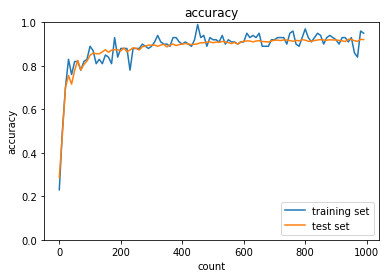

In [ ]:
# データの読み込み
(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True, one_hot_label=True)

print("データ読み込み完了")

# batch_normalizationの設定 ================================
use_batchnorm = True
#use_batchnorm = False
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[40, 20], output_size=10, activation='sigmoid', weight_init_std=0.01,
                       use_batchnorm=use_batchnorm)

iters_num = 1000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01
beta1 = 0.9
beta2 = 0.999

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval=10

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    # 勾配
    grad = network.gradient(x_batch, d_batch)
    if i == 0:
        m = {}
        v = {}
    learning_rate_t  = learning_rate * np.sqrt(1.0 - beta2 ** (i + 1)) / (1.0 - beta1 ** (i + 1))    
    for key in ('W1', 'W2', 'W3', 'b1', 'b2', 'b3'):
        if i == 0:
            m[key] = np.zeros_like(network.params[key])
            v[key] = np.zeros_like(network.params[key])
            
        m[key] += (1 - beta1) * (grad[key] - m[key])
        v[key] += (1 - beta2) * (grad[key] ** 2 - v[key])            
        network.params[key] -= learning_rate_t * m[key] / (np.sqrt(v[key]) + 1e-7)                
        
        
    if (i + 1) % plot_interval == 0:
        accr_test = network.accuracy(x_test, d_test)
        accuracies_test.append(accr_test)        
        accr_train = network.accuracy(x_batch, d_batch)
        accuracies_train.append(accr_train)
        loss = network.loss(x_batch, d_batch)
        train_loss_list.append(loss)        
        
        print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
        print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))
                

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()

- Adamで、バッチ正規化なしでは正答率80%を越えるのに200エポックかかっていたが、バッチ正規化有りだと有りだと50エポック程度で80%越える

# Section3: 過学習

## 要点のまとめ

- (復習)過学習とは、テスト誤差と訓練誤差で学習曲線に乖離が発生すること
- 過学習の要因はネットワークの自由度が高いことである
- 正則化とは、誤差関数に正則化項を加えて最適化することで、重みを抑制する手法である
- L1正則化とL2正則化がよく使われる
  - L1正則化- マンハッタン距離に基づく正則化でスパース推定が可能
  - L2正則化- ユークリッド距離に基づく正則化で縮小推定が可能
- ドロップアウトとは、ランダムにノードを削除して学習させる手法。データ量を変化させずに、異なるモデルを学習させていると解釈できる


## 確認テスト

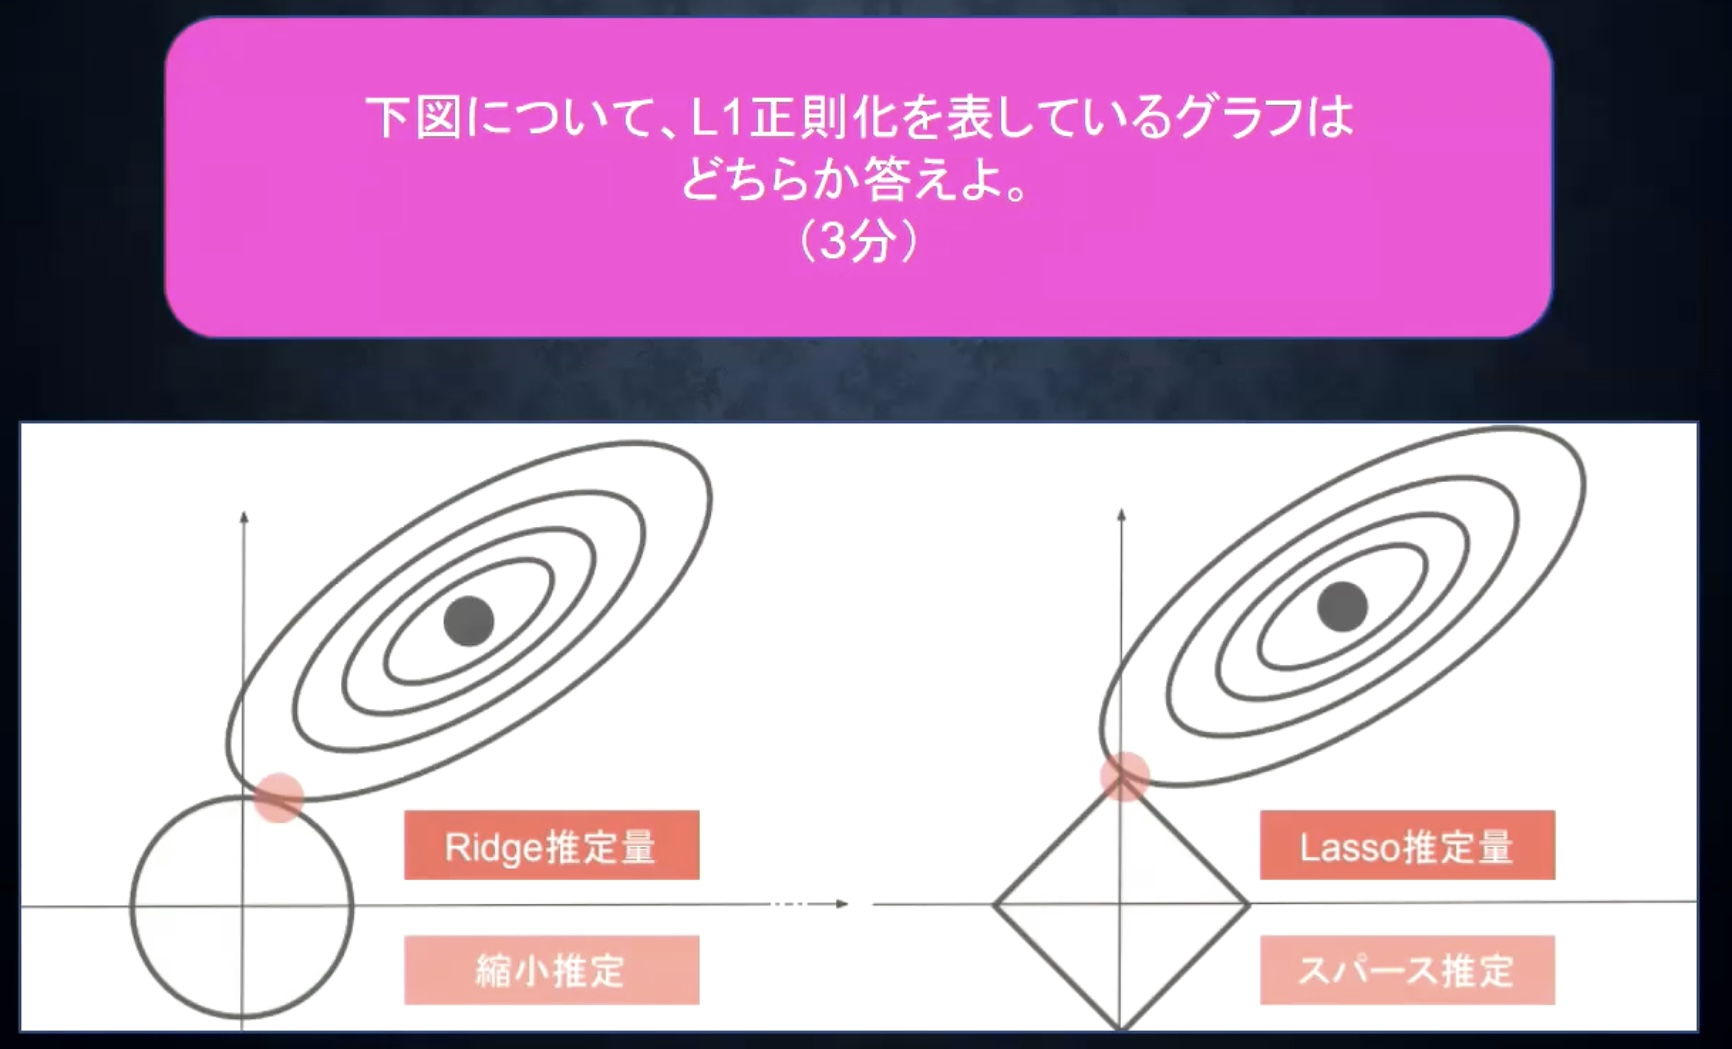

- 右のLasso推定がL1正則化

## 例題チャレンジ

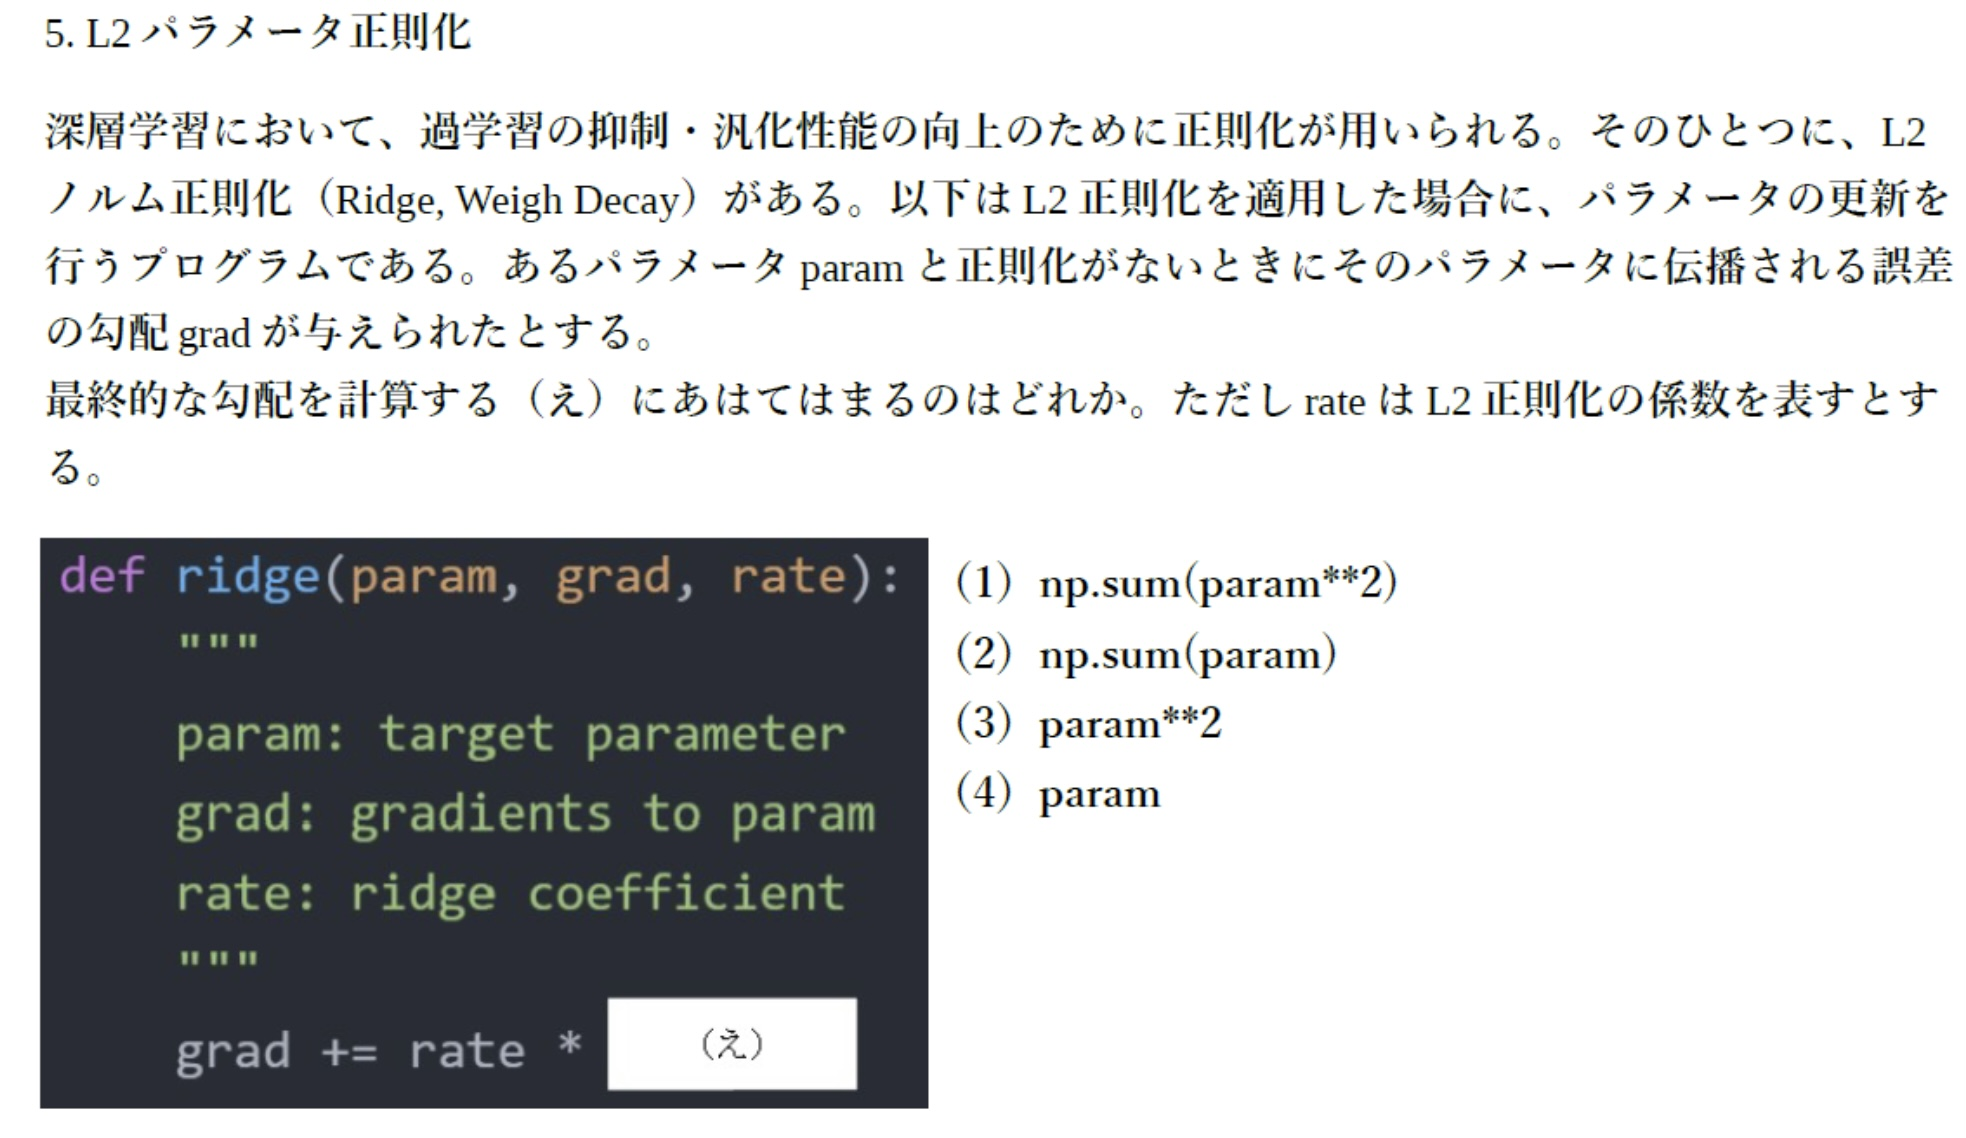

- (4)
  - 1/2 param**2を微分するとparam

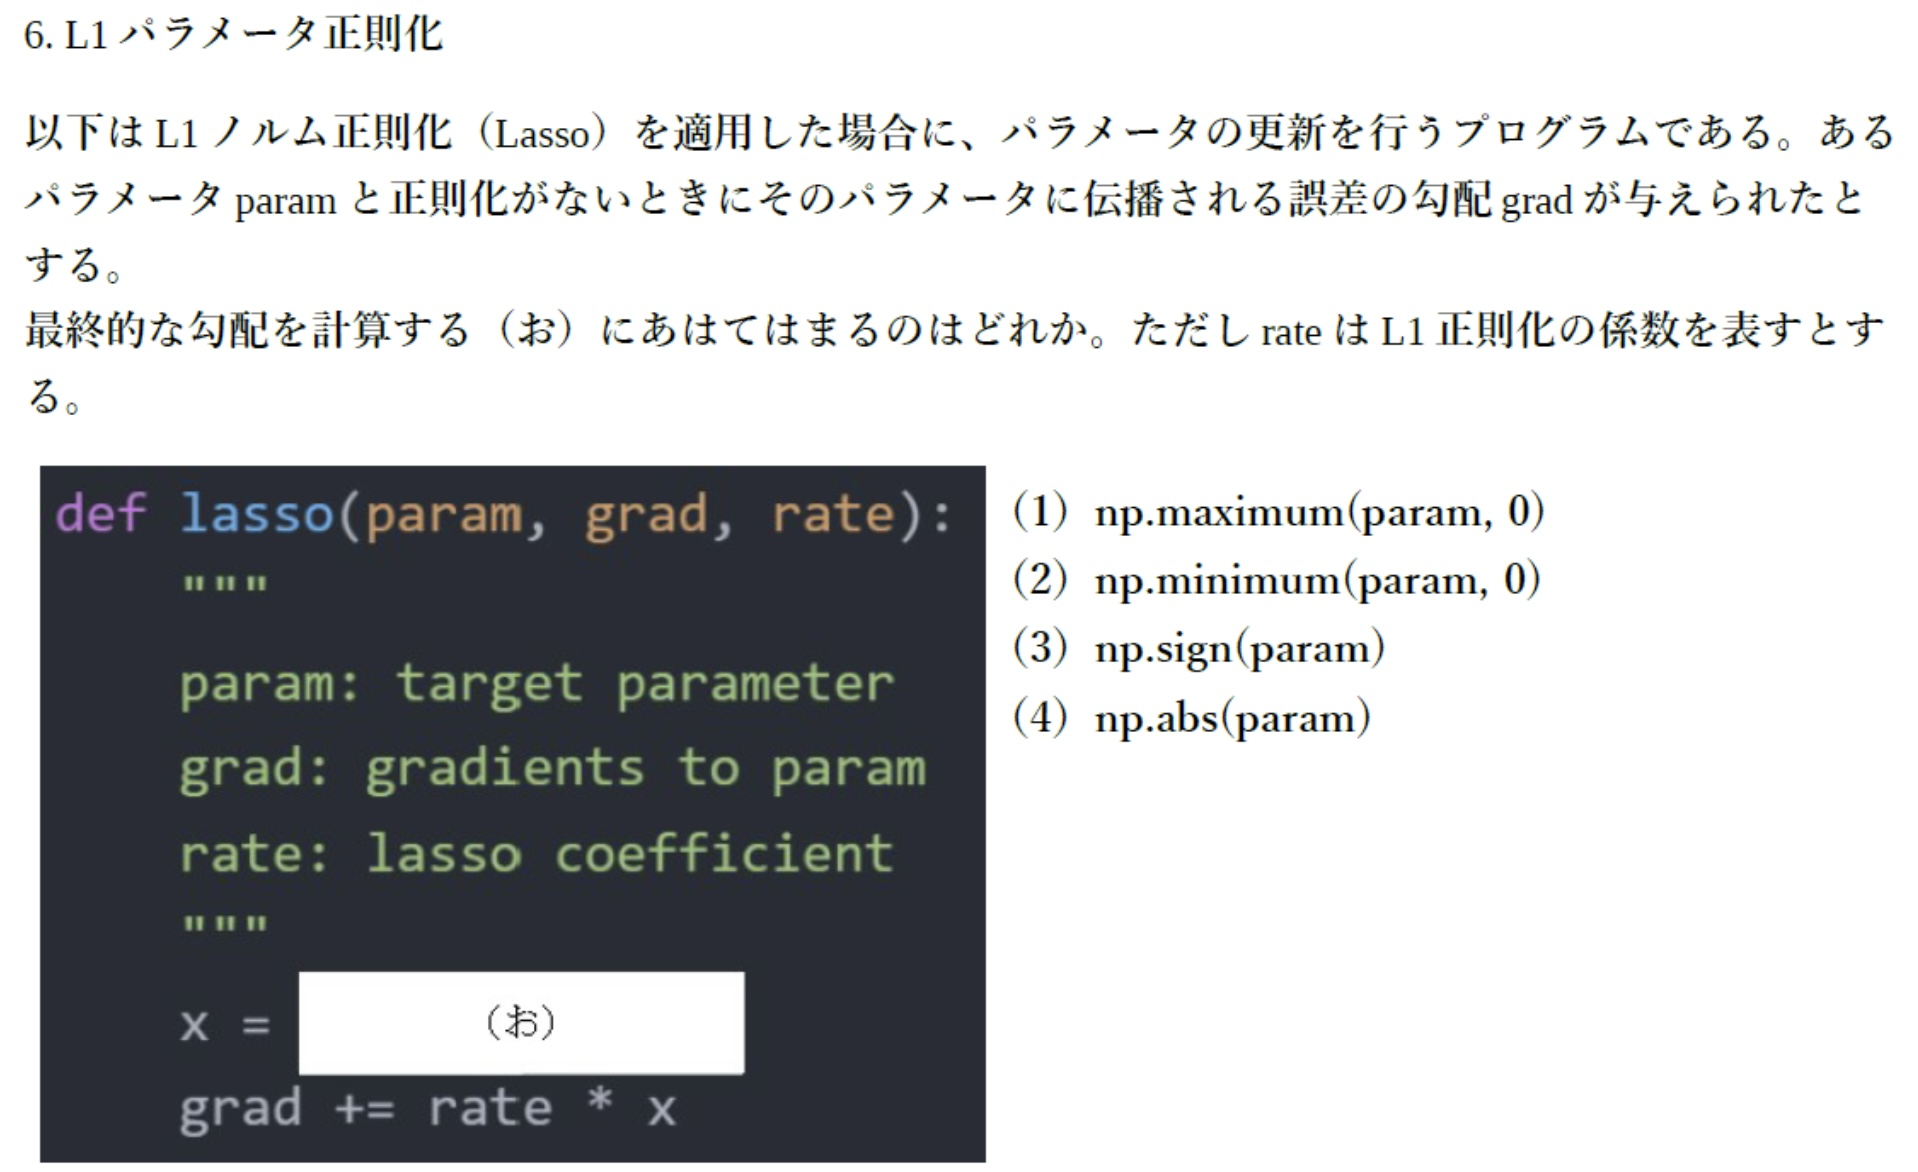

- (3)
  - |param|を微分すると符号になる。符号はnumpy.signで抽出できる

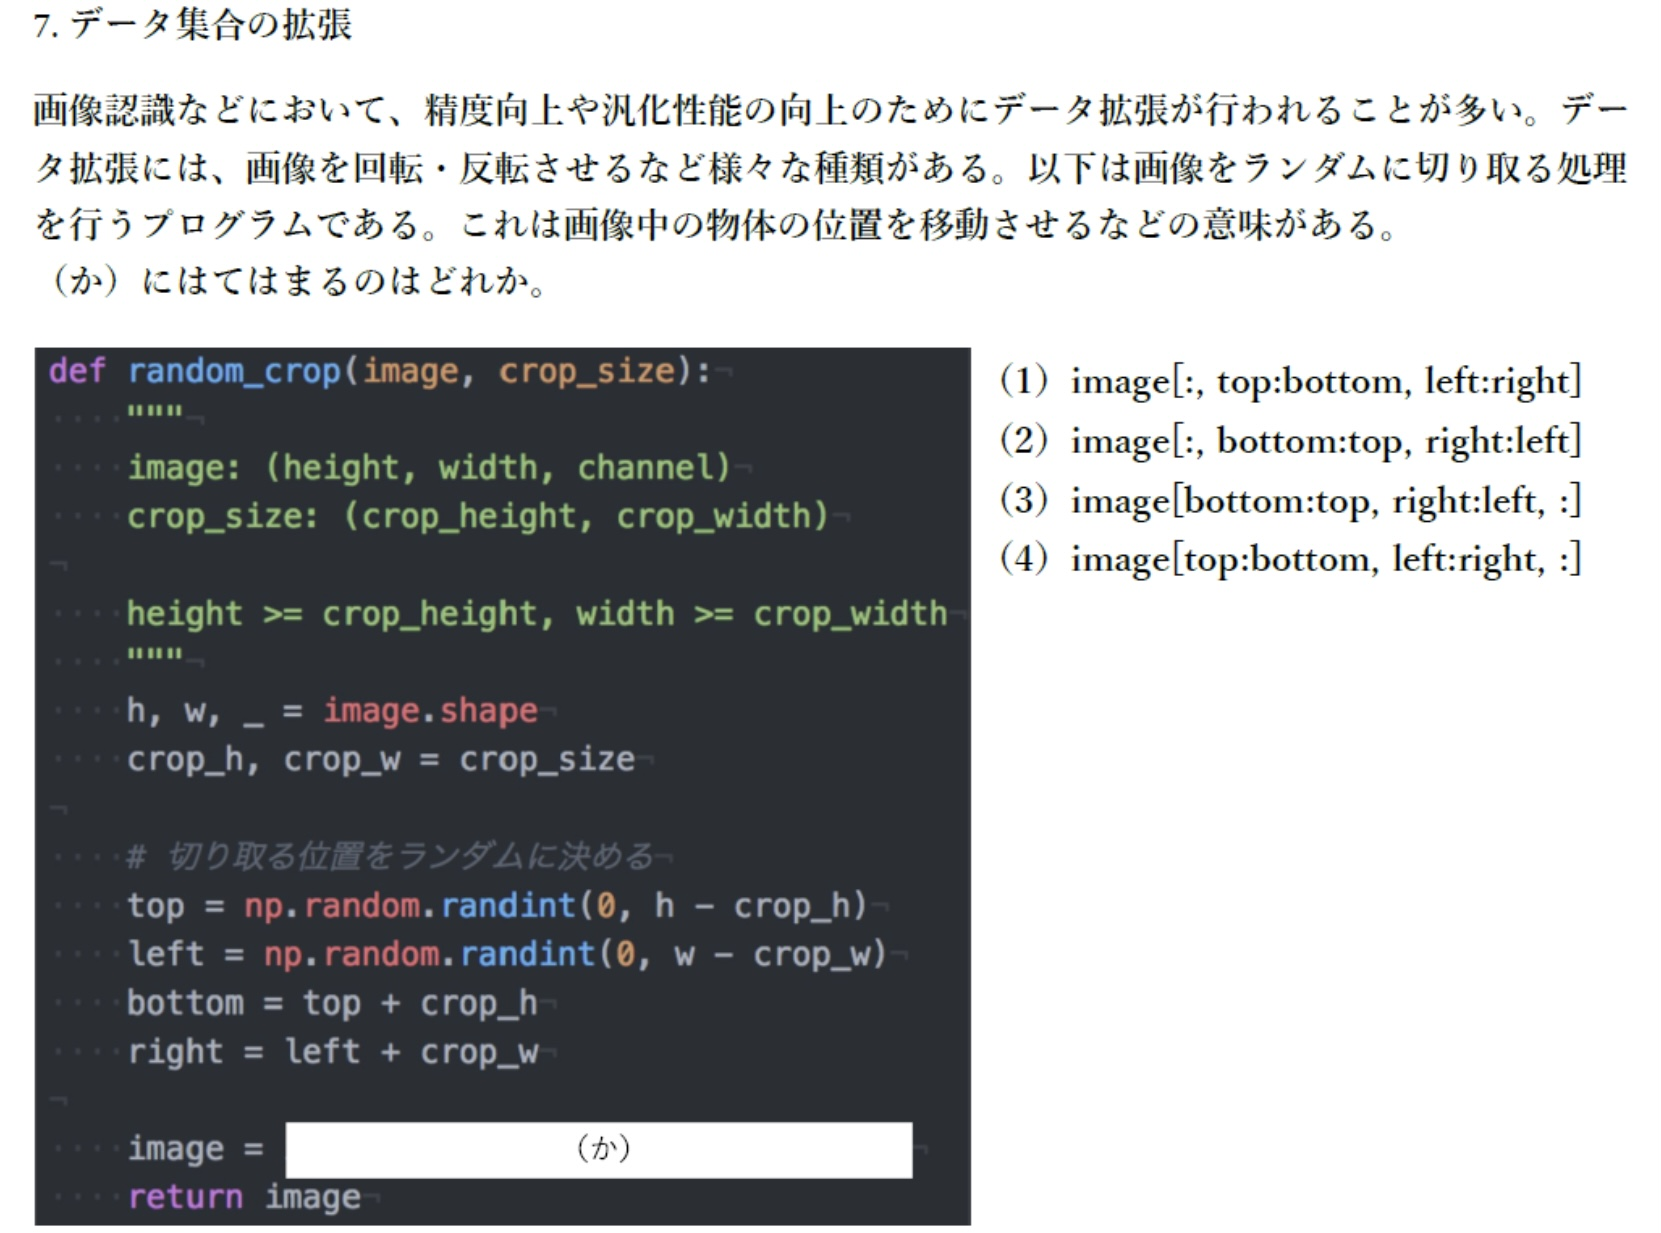

- (4)
  - 画像の形式が高さ、幅、チャネルであることを考慮する

## 過学習

データ読み込み完了
Generation: 10. 正答率(トレーニング) = 0.15333333333333332
                : 10. 正答率(テスト) = 0.1217
Generation: 20. 正答率(トレーニング) = 0.23
                : 20. 正答率(テスト) = 0.1621
Generation: 30. 正答率(トレーニング) = 0.2733333333333333
                : 30. 正答率(テスト) = 0.2086
Generation: 40. 正答率(トレーニング) = 0.3333333333333333
                : 40. 正答率(テスト) = 0.2521
Generation: 50. 正答率(トレーニング) = 0.4633333333333333
                : 50. 正答率(テスト) = 0.3275
Generation: 60. 正答率(トレーニング) = 0.5333333333333333
                : 60. 正答率(テスト) = 0.4071
Generation: 70. 正答率(トレーニング) = 0.6133333333333333
                : 70. 正答率(テスト) = 0.4594
Generation: 80. 正答率(トレーニング) = 0.6766666666666666
                : 80. 正答率(テスト) = 0.495
Generation: 90. 正答率(トレーニング) = 0.6933333333333334
                : 90. 正答率(テスト) = 0.5239
Generation: 100. 正答率(トレーニング) = 0.77
                : 100. 正答率(テスト) = 0.5777
Generation: 110. 正答率(トレーニング) = 0.75
                : 110. 正答率(テスト) = 0.5755
Generation: 120. 正答率(トレーニング) = 0.8033333333333333

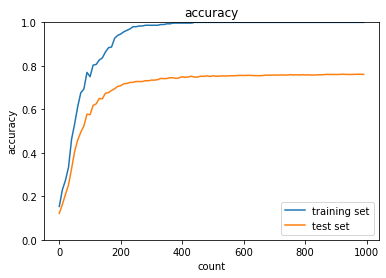

In [ ]:
(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True)

print("データ読み込み完了")

# 過学習を再現するために、学習データを削減
x_train = x_train[:300]
d_train = d_train[:300]

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10)
optimizer = optimizer.SGD(learning_rate=0.01)

iters_num = 1000
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval=10


for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    grad = network.gradient(x_batch, d_batch)
    optimizer.update(network.params, grad)

    loss = network.loss(x_batch, d_batch)
    train_loss_list.append(loss)
        
    if (i+1) % plot_interval == 0:
        accr_train = network.accuracy(x_train, d_train)
        accr_test = network.accuracy(x_test, d_test)
        accuracies_train.append(accr_train)
        accuracies_test.append(accr_test)

        print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
        print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))        

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()

## 重み減衰

### L2

データ読み込み完了
Generation: 10. 正答率(トレーニング) = 0.15666666666666668
                : 10. 正答率(テスト) = 0.1392
Generation: 20. 正答率(トレーニング) = 0.23333333333333334
                : 20. 正答率(テスト) = 0.1961
Generation: 30. 正答率(トレーニング) = 0.3
                : 30. 正答率(テスト) = 0.2675
Generation: 40. 正答率(トレーニング) = 0.41
                : 40. 正答率(テスト) = 0.3203
Generation: 50. 正答率(トレーニング) = 0.49
                : 50. 正答率(テスト) = 0.3625
Generation: 60. 正答率(トレーニング) = 0.51
                : 60. 正答率(テスト) = 0.383
Generation: 70. 正答率(トレーニング) = 0.5733333333333334
                : 70. 正答率(テスト) = 0.415
Generation: 80. 正答率(トレーニング) = 0.5833333333333334
                : 80. 正答率(テスト) = 0.426
Generation: 90. 正答率(トレーニング) = 0.64
                : 90. 正答率(テスト) = 0.4513
Generation: 100. 正答率(トレーニング) = 0.6533333333333333
                : 100. 正答率(テスト) = 0.4683
Generation: 110. 正答率(トレーニング) = 0.68
                : 110. 正答率(テスト) = 0.4982
Generation: 120. 正答率(トレーニング) = 0.72
                : 120. 正答率(テスト) = 0.5497
Generation: 130.

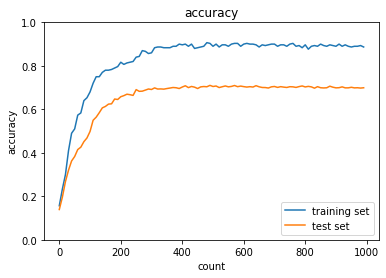

In [ ]:
(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True)

print("データ読み込み完了")

# 過学習を再現するために、学習データを削減
x_train = x_train[:300]
d_train = d_train[:300]


network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10)


iters_num = 1000
train_size = x_train.shape[0]
batch_size = 100
learning_rate=0.01

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval=10
hidden_layer_num = network.hidden_layer_num

# 正則化強度設定 ======================================
weight_decay_lambda = 0.1
# =================================================

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    grad = network.gradient(x_batch, d_batch)
    weight_decay = 0
    
    for idx in range(1, hidden_layer_num+1):
        grad['W' + str(idx)] = network.layers['Affine' + str(idx)].dW + weight_decay_lambda * network.params['W' + str(idx)]
        grad['b' + str(idx)] = network.layers['Affine' + str(idx)].db
        network.params['W' + str(idx)] -= learning_rate * grad['W' + str(idx)]
        network.params['b' + str(idx)] -= learning_rate * grad['b' + str(idx)]        
        weight_decay += 0.5 * weight_decay_lambda * np.sqrt(np.sum(network.params['W' + str(idx)] ** 2))

    loss = network.loss(x_batch, d_batch) + weight_decay
    train_loss_list.append(loss)        
        
    if (i+1) % plot_interval == 0:
        accr_train = network.accuracy(x_train, d_train)
        accr_test = network.accuracy(x_test, d_test)
        accuracies_train.append(accr_train)
        accuracies_test.append(accr_test)
        
        print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
        print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))               


lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()

- L2正則化項の追加でトレーニングで正答率100%にならなくなっている

### L1

データ読み込み完了
Generation: 10. 正答率(トレーニング) = 0.49666666666666665
                : 10. 正答率(テスト) = 0.4204
Generation: 20. 正答率(トレーニング) = 0.6733333333333333
                : 20. 正答率(テスト) = 0.5501
Generation: 30. 正答率(トレーニング) = 0.7933333333333333
                : 30. 正答率(テスト) = 0.6345
Generation: 40. 正答率(トレーニング) = 0.6866666666666666
                : 40. 正答率(テスト) = 0.5594
Generation: 50. 正答率(トレーニング) = 0.8333333333333334
                : 50. 正答率(テスト) = 0.6484
Generation: 60. 正答率(トレーニング) = 0.89
                : 60. 正答率(テスト) = 0.7319
Generation: 70. 正答率(トレーニング) = 0.64
                : 70. 正答率(テスト) = 0.4826
Generation: 80. 正答率(トレーニング) = 0.8766666666666667
                : 80. 正答率(テスト) = 0.6784
Generation: 90. 正答率(トレーニング) = 0.88
                : 90. 正答率(テスト) = 0.7172
Generation: 100. 正答率(トレーニング) = 0.8266666666666667
                : 100. 正答率(テスト) = 0.6248
Generation: 110. 正答率(トレーニング) = 0.8933333333333333
                : 110. 正答率(テスト) = 0.6833
Generation: 120. 正答率(トレーニング) = 0.843333333333333

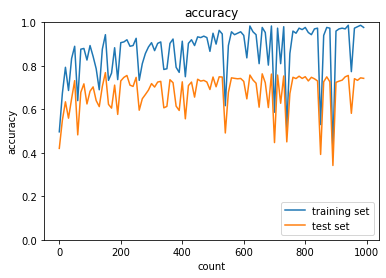

In [ ]:
(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True)

print("データ読み込み完了")

# 過学習を再現するために、学習データを削減
x_train = x_train[:300]
d_train = d_train[:300]

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10)


iters_num = 1000
train_size = x_train.shape[0]
batch_size = 100
learning_rate=0.1

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval=10
hidden_layer_num = network.hidden_layer_num

# 正則化強度設定 ======================================
weight_decay_lambda = 0.005
# =================================================

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    grad = network.gradient(x_batch, d_batch)
    weight_decay = 0
    
    for idx in range(1, hidden_layer_num+1):
        grad['W' + str(idx)] = network.layers['Affine' + str(idx)].dW + weight_decay_lambda * np.sign(network.params['W' + str(idx)])
        grad['b' + str(idx)] = network.layers['Affine' + str(idx)].db
        network.params['W' + str(idx)] -= learning_rate * grad['W' + str(idx)]
        network.params['b' + str(idx)] -= learning_rate * grad['b' + str(idx)]        
        weight_decay += weight_decay_lambda * np.sum(np.abs(network.params['W' + str(idx)]))

    loss = network.loss(x_batch, d_batch) + weight_decay
    train_loss_list.append(loss)        
        
    if (i+1) % plot_interval == 0:
        accr_train = network.accuracy(x_train, d_train)
        accr_test = network.accuracy(x_test, d_test)
        accuracies_train.append(accr_train)
        accuracies_test.append(accr_test)
        
        print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
        print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))               
                
lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()

- L2の場合と同様に、トレーニングで正答率が100％にならなくなっている

## [try] weigth_decay_lambdaの値を変更して正則化の強さを確認しよう

データ読み込み完了
Generation: 10. 正答率(トレーニング) = 0.26
                : 10. 正答率(テスト) = 0.2204
Generation: 20. 正答率(トレーニング) = 0.15
                : 20. 正答率(テスト) = 0.1261
Generation: 30. 正答率(トレーニング) = 0.11333333333333333
                : 30. 正答率(テスト) = 0.101
Generation: 40. 正答率(トレーニング) = 0.11333333333333333
                : 40. 正答率(テスト) = 0.101
Generation: 50. 正答率(トレーニング) = 0.13
                : 50. 正答率(テスト) = 0.1135
Generation: 60. 正答率(トレーニング) = 0.13
                : 60. 正答率(テスト) = 0.1135
Generation: 70. 正答率(トレーニング) = 0.13
                : 70. 正答率(テスト) = 0.1135
Generation: 80. 正答率(トレーニング) = 0.13
                : 80. 正答率(テスト) = 0.1135
Generation: 90. 正答率(トレーニング) = 0.13
                : 90. 正答率(テスト) = 0.1135
Generation: 100. 正答率(トレーニング) = 0.13
                : 100. 正答率(テスト) = 0.1135
Generation: 110. 正答率(トレーニング) = 0.13
                : 110. 正答率(テスト) = 0.1135
Generation: 120. 正答率(トレーニング) = 0.13
                : 120. 正答率(テスト) = 0.1135
Generation: 130. 正答率(トレーニング) = 0.13
                : 13

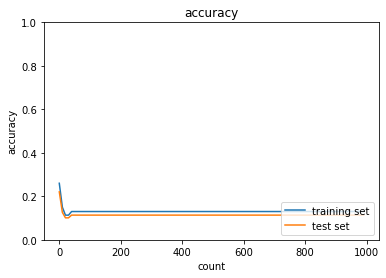

In [ ]:
(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True)

print("データ読み込み完了")

# 過学習を再現するために、学習データを削減
x_train = x_train[:300]
d_train = d_train[:300]

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10)


iters_num = 1000
train_size = x_train.shape[0]
batch_size = 100
learning_rate=0.1

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval=10
hidden_layer_num = network.hidden_layer_num

# 正則化強度設定 ======================================
weight_decay_lambda = 0.05
# =================================================

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    grad = network.gradient(x_batch, d_batch)
    weight_decay = 0
    
    for idx in range(1, hidden_layer_num+1):
        grad['W' + str(idx)] = network.layers['Affine' + str(idx)].dW + weight_decay_lambda * np.sign(network.params['W' + str(idx)])
        grad['b' + str(idx)] = network.layers['Affine' + str(idx)].db
        network.params['W' + str(idx)] -= learning_rate * grad['W' + str(idx)]
        network.params['b' + str(idx)] -= learning_rate * grad['b' + str(idx)]        
        weight_decay += weight_decay_lambda * np.sum(np.abs(network.params['W' + str(idx)]))

    loss = network.loss(x_batch, d_batch) + weight_decay
    train_loss_list.append(loss)        
        
    if (i+1) % plot_interval == 0:
        accr_train = network.accuracy(x_train, d_train)
        accr_test = network.accuracy(x_test, d_test)
        accuracies_train.append(accr_train)
        accuracies_test.append(accr_test)
        
        print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
        print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))               
                
lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()

- 10倍にすると過学習は起きないが、そもそも訓練データでも学習できない

データ読み込み完了
Generation: 10. 正答率(トレーニング) = 0.3566666666666667
                : 10. 正答率(テスト) = 0.2561
Generation: 20. 正答率(トレーニング) = 0.67
                : 20. 正答率(テスト) = 0.5159
Generation: 30. 正答率(トレーニング) = 0.5266666666666666
                : 30. 正答率(テスト) = 0.4235
Generation: 40. 正答率(トレーニング) = 0.6733333333333333
                : 40. 正答率(テスト) = 0.5586
Generation: 50. 正答率(トレーニング) = 0.53
                : 50. 正答率(テスト) = 0.4381
Generation: 60. 正答率(トレーニング) = 0.7
                : 60. 正答率(テスト) = 0.5585
Generation: 70. 正答率(トレーニング) = 0.6766666666666666
                : 70. 正答率(テスト) = 0.5503
Generation: 80. 正答率(トレーニング) = 0.64
                : 80. 正答率(テスト) = 0.5134
Generation: 90. 正答率(トレーニング) = 0.49333333333333335
                : 90. 正答率(テスト) = 0.4012
Generation: 100. 正答率(トレーニング) = 0.6666666666666666
                : 100. 正答率(テスト) = 0.5222
Generation: 110. 正答率(トレーニング) = 0.35333333333333333
                : 110. 正答率(テスト) = 0.3392
Generation: 120. 正答率(トレーニング) = 0.49666666666666665
           

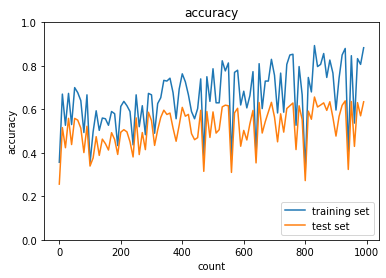

In [ ]:
(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True)

print("データ読み込み完了")

# 過学習を再現するために、学習データを削減
x_train = x_train[:300]
d_train = d_train[:300]

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10)


iters_num = 1000
train_size = x_train.shape[0]
batch_size = 100
learning_rate=0.1

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval=10
hidden_layer_num = network.hidden_layer_num

# 正則化強度設定 ======================================
weight_decay_lambda = 0.01
# =================================================

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    grad = network.gradient(x_batch, d_batch)
    weight_decay = 0
    
    for idx in range(1, hidden_layer_num+1):
        grad['W' + str(idx)] = network.layers['Affine' + str(idx)].dW + weight_decay_lambda * np.sign(network.params['W' + str(idx)])
        grad['b' + str(idx)] = network.layers['Affine' + str(idx)].db
        network.params['W' + str(idx)] -= learning_rate * grad['W' + str(idx)]
        network.params['b' + str(idx)] -= learning_rate * grad['b' + str(idx)]        
        weight_decay += weight_decay_lambda * np.sum(np.abs(network.params['W' + str(idx)]))

    loss = network.loss(x_batch, d_batch) + weight_decay
    train_loss_list.append(loss)        
        
    if (i+1) % plot_interval == 0:
        accr_train = network.accuracy(x_train, d_train)
        accr_test = network.accuracy(x_test, d_test)
        accuracies_train.append(accr_train)
        accuracies_test.append(accr_test)
        
        print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
        print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))               
                
lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()

- 2倍にするとすると、10倍の場合より訓練データで学習できる。しかし、テスト誤差と訓練誤差の乖離は元の重み減衰の場合とほとんど変わらない

## Dropout

In [ ]:
class Dropout:
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)

    def backward(self, dout):
        return dout * self.mask

データ読み込み完了
Generation: 10. 正答率(トレーニング) = 0.09333333333333334
                : 10. 正答率(テスト) = 0.0776
Generation: 20. 正答率(トレーニング) = 0.11333333333333333
                : 20. 正答率(テスト) = 0.0868
Generation: 30. 正答率(トレーニング) = 0.14333333333333334
                : 30. 正答率(テスト) = 0.1033
Generation: 40. 正答率(トレーニング) = 0.15666666666666668
                : 40. 正答率(テスト) = 0.1218
Generation: 50. 正答率(トレーニング) = 0.19333333333333333
                : 50. 正答率(テスト) = 0.1407
Generation: 60. 正答率(トレーニング) = 0.21
                : 60. 正答率(テスト) = 0.1624
Generation: 70. 正答率(トレーニング) = 0.25
                : 70. 正答率(テスト) = 0.1818
Generation: 80. 正答率(トレーニング) = 0.28
                : 80. 正答率(テスト) = 0.1975
Generation: 90. 正答率(トレーニング) = 0.29
                : 90. 正答率(テスト) = 0.2092
Generation: 100. 正答率(トレーニング) = 0.30666666666666664
                : 100. 正答率(テスト) = 0.2309
Generation: 110. 正答率(トレーニング) = 0.30666666666666664
                : 110. 正答率(テスト) = 0.2382
Generation: 120. 正答率(トレーニング) = 0.3333333333333333
      

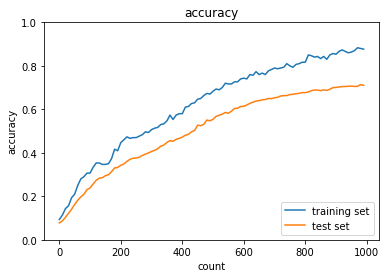

In [ ]:
from common import optimizer

(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True)

print("データ読み込み完了")

# 過学習を再現するために、学習データを削減
x_train = x_train[:300]
d_train = d_train[:300]

# ドロップアウト設定 ======================================
use_dropout = True
dropout_ratio = 0.15
# ====================================================

weight_decay_lambda = 0.01

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda, use_dropout = use_dropout, dropout_ratio = dropout_ratio)
optimizer = optimizer.SGD(learning_rate=0.01)
# optimizer = optimizer.Momentum(learning_rate=0.01, momentum=0.9)
# optimizer = optimizer.AdaGrad(learning_rate=0.01)
# optimizer = optimizer.Adam()

iters_num = 1000
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval=10


for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    grad = network.gradient(x_batch, d_batch)
    optimizer.update(network.params, grad)

    loss = network.loss(x_batch, d_batch)
    train_loss_list.append(loss)    
    
    if (i+1) % plot_interval == 0:
        accr_train = network.accuracy(x_train, d_train)
        accr_test = network.accuracy(x_test, d_test)
        accuracies_train.append(accr_train)
        accuracies_test.append(accr_test)

        print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
        print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))        
        
lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()

- L1,L2に比べて学習の進みが遅いのは、ドロップアウトでデータ量が増えたような状態になるため

## [try] dropout_ratioの値を変更してみよう

データ読み込み完了
Generation: 10. 正答率(トレーニング) = 0.09666666666666666
                : 10. 正答率(テスト) = 0.0909
Generation: 20. 正答率(トレーニング) = 0.13333333333333333
                : 20. 正答率(テスト) = 0.1045
Generation: 30. 正答率(トレーニング) = 0.13
                : 30. 正答率(テスト) = 0.1061
Generation: 40. 正答率(トレーニング) = 0.15
                : 40. 正答率(テスト) = 0.1134
Generation: 50. 正答率(トレーニング) = 0.15
                : 50. 正答率(テスト) = 0.1135
Generation: 60. 正答率(トレーニング) = 0.16
                : 60. 正答率(テスト) = 0.1265
Generation: 70. 正答率(トレーニング) = 0.15333333333333332
                : 70. 正答率(テスト) = 0.1225
Generation: 80. 正答率(トレーニング) = 0.15666666666666668
                : 80. 正答率(テスト) = 0.1218
Generation: 90. 正答率(トレーニング) = 0.15333333333333332
                : 90. 正答率(テスト) = 0.1199
Generation: 100. 正答率(トレーニング) = 0.15666666666666668
                : 100. 正答率(テスト) = 0.1194
Generation: 110. 正答率(トレーニング) = 0.15
                : 110. 正答率(テスト) = 0.1174
Generation: 120. 正答率(トレーニング) = 0.14333333333333334
                : 12

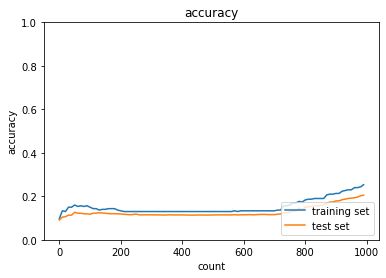

In [ ]:
from common import optimizer

(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True)

print("データ読み込み完了")

# 過学習を再現するために、学習データを削減
x_train = x_train[:300]
d_train = d_train[:300]

# ドロップアウト設定 ======================================
use_dropout = True
dropout_ratio = 0.30
# ====================================================

weight_decay_lambda = 0.01

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda, use_dropout = use_dropout, dropout_ratio = dropout_ratio)
optimizer = optimizer.SGD(learning_rate=0.01)
# optimizer = optimizer.Momentum(learning_rate=0.01, momentum=0.9)
# optimizer = optimizer.AdaGrad(learning_rate=0.01)
# optimizer = optimizer.Adam()

iters_num = 1000
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval=10


for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    grad = network.gradient(x_batch, d_batch)
    optimizer.update(network.params, grad)

    loss = network.loss(x_batch, d_batch)
    train_loss_list.append(loss)    
    
    if (i+1) % plot_interval == 0:
        accr_train = network.accuracy(x_train, d_train)
        accr_test = network.accuracy(x_test, d_test)
        accuracies_train.append(accr_train)
        accuracies_test.append(accr_test)

        print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
        print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))        
        
lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()

- ドロップアウトの割合を大きくすると学習の進みが遅くなる

## [try] optimizerとdropout_ratioの値を変更してみよう

データ読み込み完了
Generation: 10. 正答率(トレーニング) = 0.21333333333333335
                : 10. 正答率(テスト) = 0.1794
Generation: 20. 正答率(トレーニング) = 0.15333333333333332
                : 20. 正答率(テスト) = 0.1216
Generation: 30. 正答率(トレーニング) = 0.21
                : 30. 正答率(テスト) = 0.1718
Generation: 40. 正答率(トレーニング) = 0.36333333333333334
                : 40. 正答率(テスト) = 0.2951
Generation: 50. 正答率(トレーニング) = 0.35333333333333333
                : 50. 正答率(テスト) = 0.2954
Generation: 60. 正答率(トレーニング) = 0.42333333333333334
                : 60. 正答率(テスト) = 0.3856
Generation: 70. 正答率(トレーニング) = 0.43666666666666665
                : 70. 正答率(テスト) = 0.3848
Generation: 80. 正答率(トレーニング) = 0.5033333333333333
                : 80. 正答率(テスト) = 0.433
Generation: 90. 正答率(トレーニング) = 0.5133333333333333
                : 90. 正答率(テスト) = 0.4587
Generation: 100. 正答率(トレーニング) = 0.5566666666666666
                : 100. 正答率(テスト) = 0.5036
Generation: 110. 正答率(トレーニング) = 0.6266666666666667
                : 110. 正答率(テスト) = 0.5232
Generation: 120.

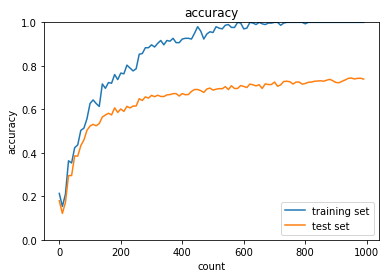

In [ ]:
from common import optimizer

(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True)

print("データ読み込み完了")

# 過学習を再現するために、学習データを削減
x_train = x_train[:300]
d_train = d_train[:300]

# ドロップアウト設定 ======================================
use_dropout = True
dropout_ratio = 0.3
# ====================================================

weight_decay_lambda = 0.01

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda, use_dropout = use_dropout, dropout_ratio = dropout_ratio)
#optimizer = optimizer.SGD(learning_rate=0.01)
# optimizer = optimizer.Momentum(learning_rate=0.01, momentum=0.9)
# optimizer = optimizer.AdaGrad(learning_rate=0.01)
optimizer = optimizer.Adam()

iters_num = 1000
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval=10


for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    grad = network.gradient(x_batch, d_batch)
    optimizer.update(network.params, grad)

    loss = network.loss(x_batch, d_batch)
    train_loss_list.append(loss)    
    
    if (i+1) % plot_interval == 0:
        accr_train = network.accuracy(x_train, d_train)
        accr_test = network.accuracy(x_test, d_test)
        accuracies_train.append(accr_train)
        accuracies_test.append(accr_test)

        print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
        print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))        
        
lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()

- 学習が進みにくいドロップアウトの割合でも、最適化手法をAdamにすると速く進むようになる。今回の設定では過学習になっており、適切な組み合わせの検討が必要だと考える

## Dropout + L1

データ読み込み完了
Generation: 10. 正答率(トレーニング) = 0.17
                : 10. 正答率(テスト) = 0.1486
Generation: 20. 正答率(トレーニング) = 0.21
                : 20. 正答率(テスト) = 0.1812
Generation: 30. 正答率(トレーニング) = 0.2633333333333333
                : 30. 正答率(テスト) = 0.2068
Generation: 40. 正答率(トレーニング) = 0.2866666666666667
                : 40. 正答率(テスト) = 0.2335
Generation: 50. 正答率(トレーニング) = 0.29333333333333333
                : 50. 正答率(テスト) = 0.2558
Generation: 60. 正答率(トレーニング) = 0.32
                : 60. 正答率(テスト) = 0.2668
Generation: 70. 正答率(トレーニング) = 0.3466666666666667
                : 70. 正答率(テスト) = 0.285
Generation: 80. 正答率(トレーニング) = 0.3566666666666667
                : 80. 正答率(テスト) = 0.2931
Generation: 90. 正答率(トレーニング) = 0.36333333333333334
                : 90. 正答率(テスト) = 0.3033
Generation: 100. 正答率(トレーニング) = 0.37
                : 100. 正答率(テスト) = 0.3093
Generation: 110. 正答率(トレーニング) = 0.39
                : 110. 正答率(テスト) = 0.3299
Generation: 120. 正答率(トレーニング) = 0.43333333333333335
                : 120. 正答

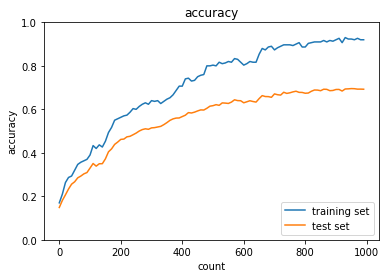

In [ ]:
(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True)

print("データ読み込み完了")

# 過学習を再現するために、学習データを削減
x_train = x_train[:300]
d_train = d_train[:300]

# ドロップアウト設定 ======================================
use_dropout = True
dropout_ratio = 0.08
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        use_dropout = use_dropout, dropout_ratio = dropout_ratio)

iters_num = 1000
train_size = x_train.shape[0]
batch_size = 100
learning_rate=0.01

train_loss_list = []
accuracies_train = []
accuracies_test = []
hidden_layer_num = network.hidden_layer_num

plot_interval=10

# 正則化強度設定 ======================================
weight_decay_lambda=0.004
# =================================================

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    grad = network.gradient(x_batch, d_batch)
    weight_decay = 0
    
    for idx in range(1, hidden_layer_num+1):
        grad['W' + str(idx)] = network.layers['Affine' + str(idx)].dW + weight_decay_lambda * np.sign(network.params['W' + str(idx)])
        grad['b' + str(idx)] = network.layers['Affine' + str(idx)].db
        network.params['W' + str(idx)] -= learning_rate * grad['W' + str(idx)]
        network.params['b' + str(idx)] -= learning_rate * grad['b' + str(idx)]        
        weight_decay += weight_decay_lambda * np.sum(np.abs(network.params['W' + str(idx)]))

    loss = network.loss(x_batch, d_batch) + weight_decay
    train_loss_list.append(loss)        
        
    if (i+1) % plot_interval == 0:
        accr_train = network.accuracy(x_train, d_train)
        accr_test = network.accuracy(x_test, d_test)
        accuracies_train.append(accr_train)
        accuracies_test.append(accr_test)
        
        print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
        print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))               
        
lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()

- ドロップアウト単独の場合と同様に学習の進みは遅いが、エポックが進むに従って正答率は上がっている

# Section4: 畳み込みニューラルネットワーク

## 要点のまとめ

- 畳み込みニューラルネットワーク(CNN)は次元間で繋がりのあるデータを扱える
- 画像の識別などでよく使われる
- 抽出した特徴量をまとめる全結合層の課題として、画像の場合、RGBの各チャンネル間の関連性が学習に反映できないということがある
- 上記の課題の対策が、畳み込み層とその演算である
- 畳み込み層の演算
  - バイアス
  - パディング (出力値のサイズを扱いやすいもの変えるため、入力値を拡張する)
  - ストライド (フィルタをずらす数。大きくすると出力サイズが小さくなる)
  - チャンネル (フィルタの数)
- プーリング層では、対象領域の最大値、または平均値を取得することで、データの特徴を把握する

## 確認テスト

- サイズサイズ6X6の入力画像を、サイズサイズ2X2のフィルタで畳み込んだときの出力画像サイズを答えよ。ただし、ストライドとパディングは1とする

高さ = (画像の高さ + 2Xパディング - フィルタの高さ)/ストライド + 1 = 7 <br>
幅 = (画像の幅 + 2Xパディング - フィルタの幅)/ストライド + 1 = 7

## simple convolution network

### image to column

In [ ]:
import pickle
from collections import OrderedDict

# 画像データを２次元配列に変換
'''
input_data: 入力値
filter_h: フィルターの高さ
filter_w: フィルターの横幅
stride: ストライド
pad: パディング
'''
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    # N: number, C: channel, H: height, W: width
    N, C, H, W = input_data.shape
    out_h = (H + 2 * pad - filter_h)//stride + 1
    out_w = (W + 2 * pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride * out_h
        for x in range(filter_w):
            x_max = x + stride * out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]
    
    col = col.transpose(0, 4, 5, 1, 2, 3) # (N, C, filter_h, filter_w, out_h, out_w) -> (N, filter_w, out_h, out_w, C, filter_h)    
    
    col = col.reshape(N * out_h * out_w, -1)
    return col

## [try] im2colの処理を確認しよう
・関数内でtransposeの処理をしている行をコメントアウトして下のコードを実行してみよう<br>
・input_dataの各次元のサイズやフィルターサイズ・ストライド・パディングを変えてみよう


In [ ]:
# im2colの処理確認
input_data = np.random.rand(2, 1, 4, 4)*100//1 # number, channel, height, widthを表す
print('========== input_data ===========\n', input_data)
print('==============================')
filter_h = 3
filter_w = 3
stride = 1
pad = 0
col = im2col(input_data, filter_h=filter_h, filter_w=filter_w, stride=stride, pad=pad)
print('============= col ==============\n', col)
print('==============================')

========== input_data ===========
 [[[[ 1. 76. 91. 33.]
   [18. 38. 22. 35.]
   [23. 68. 91. 59.]
   [82. 63. 99. 37.]]]


 [[[91. 46. 46. 74.]
   [63.  7. 93. 46.]
   [67. 82. 80.  4.]
   [37. 33. 71. 48.]]]]
============= col ==============
 [[ 1. 76. 91. 18. 38. 22. 23. 68. 91.]
 [76. 91. 33. 38. 22. 35. 68. 91. 59.]
 [18. 38. 22. 23. 68. 91. 82. 63. 99.]
 [38. 22. 35. 68. 91. 59. 63. 99. 37.]
 [91. 46. 46. 63.  7. 93. 67. 82. 80.]
 [46. 46. 74.  7. 93. 46. 82. 80.  4.]
 [63.  7. 93. 67. 82. 80. 37. 33. 71.]
 [ 7. 93. 46. 82. 80.  4. 33. 71. 48.]]


- transposeをコメントアウトしたとき

In [ ]:
# im2colの処理確認
input_data = np.random.rand(2, 1, 4, 4)*100//1 # number, channel, height, widthを表す
print('========== input_data ===========\n', input_data)
print('==============================')
filter_h = 3
filter_w = 3
stride = 1
pad = 0
col = im2col(input_data, filter_h=filter_h, filter_w=filter_w, stride=stride, pad=pad)
print('============= col ==============\n', col)
print('==============================')

========== input_data ===========
 [[[[65. 47. 34. 17.]
   [13. 42. 51.  8.]
   [92. 23. 78.  4.]
   [33.  9. 57. 12.]]]


 [[[87. 48. 27. 91.]
   [78. 50. 28. 74.]
   [42. 51. 50. 39.]
   [62. 11.  6. 59.]]]]
============= col ==============
 [[65. 47. 13. 42. 47. 34. 42. 51. 34.]
 [17. 51.  8. 13. 42. 92. 23. 42. 51.]
 [23. 78. 51.  8. 78.  4. 92. 23. 33.]
 [ 9. 23. 78.  9. 57. 78.  4. 57. 12.]
 [87. 48. 78. 50. 48. 27. 50. 28. 27.]
 [91. 28. 74. 78. 50. 42. 51. 50. 28.]
 [51. 50. 28. 74. 50. 39. 42. 51. 62.]
 [11. 51. 50. 11.  6. 50. 39.  6. 59.]]


- input_dataのチャンネルを2→3、ストライドをを1→3に変えたとき

In [ ]:
# im2colの処理確認
input_data = np.random.rand(2, 3, 4, 4)*100//1 # number, channel, height, widthを表す
print('========== input_data ===========\n', input_data)
print('==============================')
filter_h = 3
filter_w = 3
stride = 3
pad = 0
col = im2col(input_data, filter_h=filter_h, filter_w=filter_w, stride=stride, pad=pad)
print('============= col ==============\n', col)
print('==============================')

========== input_data ===========
 [[[[35. 24. 93. 34.]
   [75. 66. 53. 52.]
   [37. 15. 32. 81.]
   [ 8. 85. 25. 44.]]

  [[60. 16. 95. 83.]
   [ 5.  5. 85. 55.]
   [29. 39. 68.  6.]
   [22. 14. 23. 35.]]

  [[28.  5. 36. 17.]
   [85. 13. 15. 94.]
   [34. 24. 92. 16.]
   [69. 97. 91. 61.]]]


 [[[81. 70. 72. 56.]
   [51. 14.  8. 33.]
   [74. 56. 79. 86.]
   [97. 46. 59. 41.]]

  [[59. 60. 91. 13.]
   [81.  9. 77. 74.]
   [46. 48. 42. 22.]
   [58. 44. 24.  5.]]

  [[66. 58. 14. 64.]
   [44. 71. 65. 81.]
   [20. 40.  4. 18.]
   [35. 10. 92.  9.]]]]
============= col ==============
 [[35. 24. 93. 75. 66. 53. 37. 15. 32. 60. 16. 95.  5.  5. 85. 29. 39. 68.
  28.  5. 36. 85. 13. 15. 34. 24. 92.]
 [81. 70. 72. 51. 14.  8. 74. 56. 79. 59. 60. 91. 81.  9. 77. 46. 48. 42.
  66. 58. 14. 44. 71. 65. 20. 40.  4.]]


### column to image

In [ ]:
# ２次元配列を画像データに変換
def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    # N: number, C: channel, H: height, W: width
    N, C, H, W = input_shape
    # 切り捨て除算    
    out_h = (H + 2 * pad - filter_h)//stride + 1
    out_w = (W + 2 * pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2) # (N, filter_h, filter_w, out_h, out_w, C)

    img = np.zeros((N, C, H + 2 * pad + stride - 1, W + 2 * pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride * out_h
        for x in range(filter_w):
            x_max = x + stride * out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

## col2imの処理を確認しよう
・im2colの確認で出力したcolをimageに変換して確認しよう

In [ ]:
img = col2im(col, input_shape=input_data.shape, filter_h=filter_h, filter_w=filter_w, stride=stride, pad=pad)
print(img)

[[[[35. 24. 93.  0.]
   [75. 66. 53.  0.]
   [37. 15. 32.  0.]
   [ 0.  0.  0.  0.]]

  [[60. 16. 95.  0.]
   [ 5.  5. 85.  0.]
   [29. 39. 68.  0.]
   [ 0.  0.  0.  0.]]

  [[28.  5. 36.  0.]
   [85. 13. 15.  0.]
   [34. 24. 92.  0.]
   [ 0.  0.  0.  0.]]]


 [[[81. 70. 72.  0.]
   [51. 14.  8.  0.]
   [74. 56. 79.  0.]
   [ 0.  0.  0.  0.]]

  [[59. 60. 91.  0.]
   [81.  9. 77.  0.]
   [46. 48. 42.  0.]
   [ 0.  0.  0.  0.]]

  [[66. 58. 14.  0.]
   [44. 71. 65.  0.]
   [20. 40.  4.  0.]
   [ 0.  0.  0.  0.]]]]


## convolution class

In [ ]:
class Convolution:
    # W: フィルター, b: バイアス
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
        # 中間データ（backward時に使用）
        self.x = None   
        self.col = None
        self.col_W = None
        
        # フィルター・バイアスパラメータの勾配
        self.dW = None
        self.db = None

    def forward(self, x):
        # FN: filter_number, C: channel, FH: filter_height, FW: filter_width
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        # 出力値のheight, width
        out_h = 1 + int((H + 2 * self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2 * self.pad - FW) / self.stride)
        
        # xを行列に変換
        col = im2col(x, FH, FW, self.stride, self.pad)
        # フィルターをxに合わせた行列に変換
        col_W = self.W.reshape(FN, -1).T

        out = np.dot(col, col_W) + self.b
        # 計算のために変えた形式を戻す
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        self.x = x
        self.col = col
        self.col_W = col_W

        return out

    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0, 2, 3, 1).reshape(-1, FN)

        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol = np.dot(dout, self.col_W.T)
        # dcolを画像データに変換
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

        return dx


## pooling class

In [ ]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
        self.x = None
        self.arg_max = None

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)
        
        # xを行列に変換
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        # プーリングのサイズに合わせてリサイズ
        col = col.reshape(-1, self.pool_h*self.pool_w)
        
        # 行ごとに最大値を求める
        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        # 整形
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.x = x
        self.arg_max = arg_max

        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dx


## sinple convolution network class

In [ ]:
class SimpleConvNet:
    # conv - relu - pool - affine - relu - affine - softmax
    def __init__(self, input_dim=(1, 28, 28), conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']        
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2 * filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size / 2) * (conv_output_size / 2))

        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Conv1'] = layers.Convolution(self.params['W1'], self.params['b1'], conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = layers.Relu()
        self.layers['Pool1'] = layers.Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = layers.Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = layers.Relu()
        self.layers['Affine2'] = layers.Affine(self.params['W3'], self.params['b3'])

        self.last_layer = layers.SoftmaxWithLoss()

    def predict(self, x):
        for key in self.layers.keys():
            x = self.layers[key].forward(x)
        return x
        
    def loss(self, x, d):
        y = self.predict(x)
        return self.last_layer.forward(y, d)

    def accuracy(self, x, d, batch_size=100):
        if d.ndim != 1 : d = np.argmax(d, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            td = d[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == td) 
        
        return acc / x.shape[0]

    def gradient(self, x, d):
        # forward
        self.loss(x, d)
        
        # backward
        dout = 1
        dout = self.last_layer.backward(dout)
        layers = list(self.layers.values())
        
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grad = {}
        grad['W1'], grad['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grad['W2'], grad['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grad['W3'], grad['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grad

データ読み込み完了
Generation: 10. 正答率(トレーニング) = 0.4058
                : 10. 正答率(テスト) = 0.362
Generation: 20. 正答率(トレーニング) = 0.653
                : 20. 正答率(テスト) = 0.605
Generation: 30. 正答率(トレーニング) = 0.7122
                : 30. 正答率(テスト) = 0.672
Generation: 40. 正答率(トレーニング) = 0.7836
                : 40. 正答率(テスト) = 0.756
Generation: 50. 正答率(トレーニング) = 0.837
                : 50. 正答率(テスト) = 0.81
Generation: 60. 正答率(トレーニング) = 0.8646
                : 60. 正答率(テスト) = 0.838
Generation: 70. 正答率(トレーニング) = 0.8746
                : 70. 正答率(テスト) = 0.84
Generation: 80. 正答率(トレーニング) = 0.8884
                : 80. 正答率(テスト) = 0.854
Generation: 90. 正答率(トレーニング) = 0.886
                : 90. 正答率(テスト) = 0.862
Generation: 100. 正答率(トレーニング) = 0.9026
                : 100. 正答率(テスト) = 0.868
Generation: 110. 正答率(トレーニング) = 0.9102
                : 110. 正答率(テスト) = 0.879
Generation: 120. 正答率(トレーニング) = 0.9124
                : 120. 正答率(テスト) = 0.874
Generation: 130. 正答率(トレーニング) = 0.9052
                : 130. 正答率(テスト) = 0.881

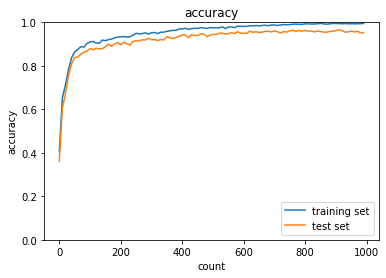

In [ ]:
from common import optimizer

# データの読み込み
(x_train, d_train), (x_test, d_test) = load_mnist(flatten=False)

print("データ読み込み完了")

# 処理に時間のかかる場合はデータを削減 
x_train, d_train = x_train[:5000], d_train[:5000]
x_test, d_test = x_test[:1000], d_test[:1000]


network = SimpleConvNet(input_dim=(1,28,28), conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)

optimizer = optimizer.Adam()

iters_num = 1000
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval=10



for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]
    
    grad = network.gradient(x_batch, d_batch)
    optimizer.update(network.params, grad)

    loss = network.loss(x_batch, d_batch)
    train_loss_list.append(loss)

    if (i+1) % plot_interval == 0:
        accr_train = network.accuracy(x_train, d_train)
        accr_test = network.accuracy(x_test, d_test)
        accuracies_train.append(accr_train)
        accuracies_test.append(accr_test)
        
        print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
        print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))               

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()

# Section5: 最新のCNN

## 要点のまとめ

## AlexNet

- AlexNetは大規模画像の識別のための畳み込みニューラルネットワークである
- 5層の畳み込み層およびプーリング層など、それに続く3層の全結合層から構成される
- 過学習を防ぐために、サイズサイズ4096の全結合層の出力にドロップアウトプットを使用している

## double_comvolution_network

In [ ]:
import pickle
from collections import OrderedDict

class DoubleConvNet:
    # conv - relu - conv - relu - pool - affine - relu - affine - softmax
    def __init__(self, input_dim=(1, 28, 28),
                 conv_param_1={'filter_num':10, 'filter_size':7, 'pad':1, 'stride':1},
                 conv_param_2={'filter_num':20, 'filter_size':3, 'pad':1, 'stride':1},
                 hidden_size=50, output_size=10, weight_init_std=0.01):
        conv_output_size_1 = (input_dim[1] - conv_param_1['filter_size'] + 2 * conv_param_1['pad']) / conv_param_1['stride'] + 1
        conv_output_size_2 = (conv_output_size_1 - conv_param_2['filter_size'] + 2 * conv_param_2['pad']) / conv_param_2['stride'] + 1        
        pool_output_size = int(conv_param_2['filter_num'] * (conv_output_size_2 / 2) * (conv_output_size_2 / 2))        
        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(conv_param_1['filter_num'], input_dim[0], conv_param_1['filter_size'], conv_param_1['filter_size'])
        self.params['b1'] = np.zeros(conv_param_1['filter_num'])
        self.params['W2'] = weight_init_std * np.random.randn(conv_param_2['filter_num'], conv_param_1['filter_num'], conv_param_2['filter_size'], conv_param_2['filter_size'])
        self.params['b2'] = np.zeros(conv_param_2['filter_num'])
        self.params['W3'] = weight_init_std * np.random.randn(pool_output_size, hidden_size)
        self.params['b3'] = np.zeros(hidden_size)
        self.params['W4'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b4'] = np.zeros(output_size)
        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Conv1'] = layers.Convolution(self.params['W1'], self.params['b1'], conv_param_1['stride'], conv_param_1['pad'])
        self.layers['Relu1'] = layers.Relu()
        self.layers['Conv2'] = layers.Convolution(self.params['W2'], self.params['b2'], conv_param_2['stride'], conv_param_2['pad'])
        self.layers['Relu2'] = layers.Relu()
        self.layers['Pool1'] = layers.Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = layers.Affine(self.params['W3'], self.params['b3'])
        self.layers['Relu3'] = layers.Relu()
        self.layers['Affine2'] = layers.Affine(self.params['W4'], self.params['b4'])
        self.last_layer = layers.SoftmaxWithLoss()

    def predict(self, x):
        for key in self.layers.keys():
            x = self.layers[key].forward(x)
        return x
        
    def loss(self, x, d):
        y = self.predict(x)
        return self.last_layer.forward(y, d)

    def accuracy(self, x, d, batch_size=100):
        if d.ndim != 1 : d = np.argmax(d, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            td = d[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == td) 
        
        return acc / x.shape[0]

    def gradient(self, x, d):
        # forward
        self.loss(x, d)
        
        # backward
        dout = 1
        dout = self.last_layer.backward(dout)
        layers = list(self.layers.values())
        
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grad = {}
        grad['W1'], grad['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grad['W2'], grad['b2'] = self.layers['Conv2'].dW, self.layers['Conv2'].db        
        grad['W3'], grad['b3'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grad['W4'], grad['b4'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grad

データ読み込み完了
Generation: 10. 正答率(トレーニング) = 0.2642
                : 10. 正答率(テスト) = 0.27
Generation: 20. 正答率(トレーニング) = 0.3772
                : 20. 正答率(テスト) = 0.407
Generation: 30. 正答率(トレーニング) = 0.6
                : 30. 正答率(テスト) = 0.564
Generation: 40. 正答率(トレーニング) = 0.7474
                : 40. 正答率(テスト) = 0.706
Generation: 50. 正答率(トレーニング) = 0.7774
                : 50. 正答率(テスト) = 0.739
Generation: 60. 正答率(トレーニング) = 0.8022
                : 60. 正答率(テスト) = 0.769
Generation: 70. 正答率(トレーニング) = 0.8254
                : 70. 正答率(テスト) = 0.803
Generation: 80. 正答率(トレーニング) = 0.8478
                : 80. 正答率(テスト) = 0.827
Generation: 90. 正答率(トレーニング) = 0.8318
                : 90. 正答率(テスト) = 0.804
Generation: 100. 正答率(トレーニング) = 0.8678
                : 100. 正答率(テスト) = 0.841


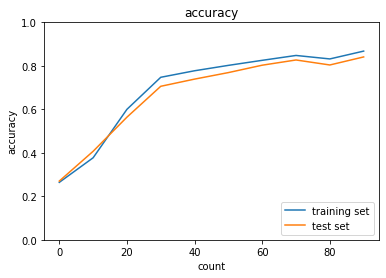

In [ ]:
# データの読み込み
(x_train, d_train), (x_test, d_test) = load_mnist(flatten=False)

print("データ読み込み完了")
# 処理に時間のかかる場合はデータを削減 
x_train, d_train = x_train[:5000], d_train[:5000]
x_test, d_test = x_test[:1000], d_test[:1000]


network = DoubleConvNet(input_dim=(1,28,28), 
                          conv_param_1={'filter_num':10, 'filter_size':7, 'pad':1, 'stride':1},
                          conv_param_2={'filter_num':20, 'filter_size':3, 'pad':1, 'stride':1},
                          hidden_size=100, output_size=10, weight_init_std=0.01)

optimizer = optimizer.Adam()

# 時間がかかるため100に設定
iters_num = 100
# iters_num = 1000
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval=10



for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]
    
    grad = network.gradient(x_batch, d_batch)
    optimizer.update(network.params, grad)
    loss = network.loss(x_batch, d_batch)
    train_loss_list.append(loss)

    if (i+1) % plot_interval == 0:
        accr_train = network.accuracy(x_train, d_train)
        accr_test = network.accuracy(x_test, d_test)
        accuracies_train.append(accr_train)
        accuracies_test.append(accr_test)
        
        print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
        print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))               

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()

## deep convolution network

In [ ]:
class DeepConvNet:
    '''
    認識率99%以上の高精度なConvNet

    conv - relu - conv- relu - pool -
    conv - relu - conv- relu - pool -
    conv - relu - conv- relu - pool -
    affine - relu - dropout - affine - dropout - softmax
    '''
    def __init__(self, input_dim=(1, 28, 28),
                 conv_param_1 = {'filter_num':16, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_2 = {'filter_num':16, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_3 = {'filter_num':32, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_4 = {'filter_num':32, 'filter_size':3, 'pad':2, 'stride':1},
                 conv_param_5 = {'filter_num':64, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_6 = {'filter_num':64, 'filter_size':3, 'pad':1, 'stride':1},
                 hidden_size=50, output_size=10):
        # 重みの初期化===========
        # 各層のニューロンひとつあたりが、前層のニューロンといくつのつながりがあるか
        pre_node_nums = np.array([1*3*3, 16*3*3, 16*3*3, 32*3*3, 32*3*3, 64*3*3, 64*4*4, hidden_size])
        wight_init_scales = np.sqrt(2.0 / pre_node_nums)  # Heの初期値
        
        self.params = {}
        pre_channel_num = input_dim[0]
        for idx, conv_param in enumerate([conv_param_1, conv_param_2, conv_param_3, conv_param_4, conv_param_5, conv_param_6]):
            self.params['W' + str(idx+1)] = wight_init_scales[idx] * np.random.randn(conv_param['filter_num'], pre_channel_num, conv_param['filter_size'], conv_param['filter_size'])
            self.params['b' + str(idx+1)] = np.zeros(conv_param['filter_num'])
            pre_channel_num = conv_param['filter_num']
        self.params['W7'] = wight_init_scales[6] * np.random.randn(pre_node_nums[6], hidden_size)
        print(self.params['W7'].shape)
        self.params['b7'] = np.zeros(hidden_size)
        self.params['W8'] = wight_init_scales[7] * np.random.randn(pre_node_nums[7], output_size)
        self.params['b8'] = np.zeros(output_size)

        # レイヤの生成===========
        self.layers = []
        self.layers.append(layers.Convolution(self.params['W1'], self.params['b1'], 
                           conv_param_1['stride'], conv_param_1['pad']))
        self.layers.append(layers.Relu())
        self.layers.append(layers.Convolution(self.params['W2'], self.params['b2'], 
                           conv_param_2['stride'], conv_param_2['pad']))
        self.layers.append(layers.Relu())
        self.layers.append(layers.Pooling(pool_h=2, pool_w=2, stride=2))
        self.layers.append(layers.Convolution(self.params['W3'], self.params['b3'], 
                           conv_param_3['stride'], conv_param_3['pad']))
        self.layers.append(layers.Relu())
        self.layers.append(layers.Convolution(self.params['W4'], self.params['b4'],
                           conv_param_4['stride'], conv_param_4['pad']))
        self.layers.append(layers.Relu())
        self.layers.append(layers.Pooling(pool_h=2, pool_w=2, stride=2))
        self.layers.append(layers.Convolution(self.params['W5'], self.params['b5'],
                           conv_param_5['stride'], conv_param_5['pad']))
        self.layers.append(layers.Relu())
        self.layers.append(layers.Convolution(self.params['W6'], self.params['b6'],
                           conv_param_6['stride'], conv_param_6['pad']))
        self.layers.append(layers.Relu())
        self.layers.append(layers.Pooling(pool_h=2, pool_w=2, stride=2))
        self.layers.append(layers.Affine(self.params['W7'], self.params['b7']))
        self.layers.append(layers.Relu())
        self.layers.append(layers.Dropout(0.5))
        self.layers.append(layers.Affine(self.params['W8'], self.params['b8']))
        self.layers.append(layers.Dropout(0.5))
        
        self.last_layer = layers.SoftmaxWithLoss()

    def predict(self, x, train_flg=False):
        for layer in self.layers:
            if isinstance(layer, layers.Dropout):
                x = layer.forward(x, train_flg)
            else:
                x = layer.forward(x)
        return x

    def loss(self, x, d):
        y = self.predict(x, train_flg=True)
        return self.last_layer.forward(y, d)

    def accuracy(self, x, d, batch_size=100):
        if d.ndim != 1 : d = np.argmax(d, axis=1)

        acc = 0.0

        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            td = d[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx, train_flg=False)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == td)

        return acc / x.shape[0]

    def gradient(self, x, d):
        # forward
        self.loss(x, d)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        tmp_layers = self.layers.copy()
        tmp_layers.reverse()
        for layer in tmp_layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        for i, layer_idx in enumerate((0, 2, 5, 7, 10, 12, 15, 18)):
            grads['W' + str(i+1)] = self.layers[layer_idx].dW
            grads['b' + str(i+1)] = self.layers[layer_idx].db

        return grads

データ読み込み完了
(1024, 50)
Generation: 10. 正答率(トレーニング) = 0.3468
                : 10. 正答率(テスト) = 0.313
Generation: 20. 正答率(トレーニング) = 0.5278
                : 20. 正答率(テスト) = 0.502
Generation: 30. 正答率(トレーニング) = 0.6974
                : 30. 正答率(テスト) = 0.677
Generation: 40. 正答率(トレーニング) = 0.6898
                : 40. 正答率(テスト) = 0.675
Generation: 50. 正答率(トレーニング) = 0.8434
                : 50. 正答率(テスト) = 0.825
Generation: 60. 正答率(トレーニング) = 0.8758
                : 60. 正答率(テスト) = 0.859
Generation: 70. 正答率(トレーニング) = 0.9102
                : 70. 正答率(テスト) = 0.889
Generation: 80. 正答率(トレーニング) = 0.9168
                : 80. 正答率(テスト) = 0.898
Generation: 90. 正答率(トレーニング) = 0.931
                : 90. 正答率(テスト) = 0.902
Generation: 100. 正答率(トレーニング) = 0.9464
                : 100. 正答率(テスト) = 0.921
Generation: 110. 正答率(トレーニング) = 0.9448
                : 110. 正答率(テスト) = 0.923
Generation: 120. 正答率(トレーニング) = 0.946
                : 120. 正答率(テスト) = 0.929
Generation: 130. 正答率(トレーニング) = 0.959
                : 130. 正答率

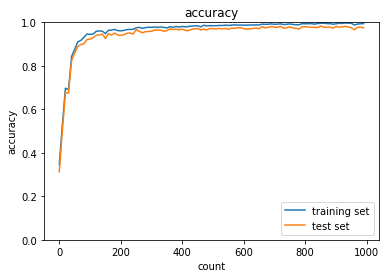

In [ ]:
from common import optimizer

(x_train, d_train), (x_test, d_test) = load_mnist(flatten=False)

# 処理に時間のかかる場合はデータを削減 
x_train, d_train = x_train[:5000], d_train[:5000]
x_test, d_test = x_test[:1000], d_test[:1000]

print("データ読み込み完了")

network = DeepConvNet()  
optimizer = optimizer.Adam()

iters_num = 1000
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval=10


for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]
    
    grad = network.gradient(x_batch, d_batch)
    optimizer.update(network.params, grad)

    loss = network.loss(x_batch, d_batch)
    train_loss_list.append(loss)

    if (i+1) % plot_interval == 0:
        accr_train = network.accuracy(x_train, d_train)
        accr_test = network.accuracy(x_test, d_test)
        accuracies_train.append(accr_train)
        accuracies_test.append(accr_test)
        
        print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
        print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))               

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()